In [0]:
import argparse

import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K

In [0]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, mu, sigma, input_dim):
        """
        ex) real_sample(n) -> (n, input_dim) data generate
        :param mu: mean of data
        :param sigma: sigma of data
        :param input_dim: input dimension
        """
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, input_dim))
        self.z_sample = lambda n_batch: np.random.rand(n_batch, input_dim)


optimizer = Adam(lr=2e-4, beta_1=0.9, beta_2=0.999)


class GAN:
    """
    Define GAN model
    """
    def __init__(self, learning_rate, input_dim):
        self.learning_rate = learning_rate
        self.input_dim = input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.makeGD()
        # self._optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)

    def discriminator(self):
        D = models.Sequential()
        D.add(Dense(50, activation='relu', input_shape=(self.input_dim,))) # np.shape(100) == np.shape(100,)과 같은것
        D.add(Dense(50, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))
        D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return D

    def generator(self):
        G = models.Sequential()
        G.add(Reshape((self.input_dim, 1), input_shape=(self.input_dim,)))
        G.add(Conv1D(50, 1, activation='relu'))
        G.add(Conv1D(50, 1, activation='sigmoid'))
        G.add(Conv1D(1, 1))
        G.add(Flatten())
        G.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return G

    def makeGD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        GD.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        D.trainable = True
        return GD


class Model:
    """
    Learner class
    """
    def __init__(self, mu, sigma, batch_size, epochs, learning_rate, input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.data = Data(mu, sigma, input_dim)
        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, input_dim)

    def fit(self):
        """
        train model while epoch
        """
        for epoch in range(self.epochs):
            # train discriminator by real data
            for iter in range(self.n_iter_D):
                self.train_D()

            # train GD by generated fake data
            for iter in range(self.n_iter_G):
                self.train_GD()

            # print and show each 10n epoch
            if (epoch + 1) % 100 == 0:
                gan = self.gan
                data = self.data
                z = data.z_sample(100)
                gen = gan.G.predict(z)
                real = data.real_sample(100)
                self.show_hist(real, gen, z)
                self.print_stats(epoch, real, gen)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.real_sample(self.batch_size)

        # Generated data
        z = self.data.z_sample(self.batch_size)
        gen = self.gan.G.predict(z)

        # train discriminator
        self.gan.D.trainable = True
        x = np.concatenate([real, gen], axis=0)
        y = np.array([1] * real.shape[0] + [0] * gen.shape[0])
        self.gan.D.train_on_batch(x, y)

    def train_GD(self):
        """
        train Generator (Not Discriminator)
        """

        # seed data for data generation
        z = self.data.z_sample(self.batch_size)

        # only train generator
        self.gan.D.trainable = False

        # train generator
        y = np.array([1] * z.shape[0])
        self.gan.GD.train_on_batch(z, y)

    def show_hist(self, real, gen, z):
        """
        hist on specific train epoch, show generator input z, generated gen, data of real
        """
        plt.hist(real.reshape(-1), histtype='step', label='Real')
        plt.hist(gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)
        plt.show()

    def print_stats(self, epoch, real, gen):
        """
        print real data and generated data
        """
        print('epoch:', str(epoch), '//', 'mu and std of Real:', (np.mean(real), np.std(real)))
        print('mu and std of Gen:', (np.mean(gen), np.std(gen)))


def main():
    # set hyper parameters
    mu = 4
    sigma = 1.25
    batch_size = 200
    epochs = 5000
    learning_rate = 2e-4
    input_dim = 100
    n_iter_D = 1
    n_iter_G = 5

    # run model
    model = Model(mu, sigma, batch_size, epochs, learning_rate, input_dim, n_iter_D, n_iter_G)
    model.fit()

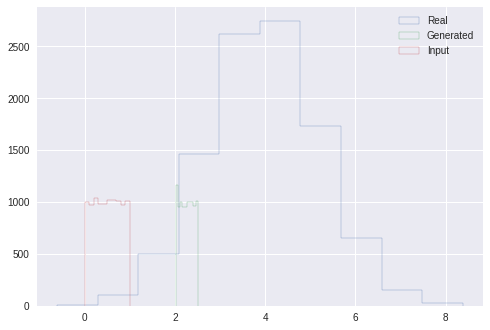

epoch: 9 // mu and std of Real: (3.9852667657904792, 1.227821400631172)
mu and std of Gen: (2.2548313, 0.14418665)


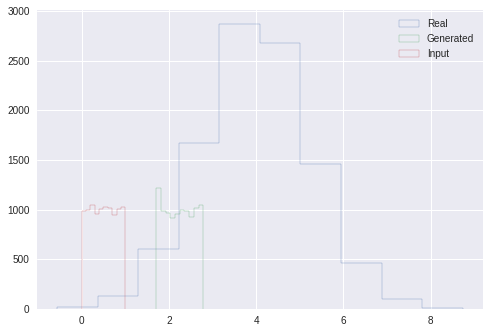

epoch: 19 // mu and std of Real: (4.003605582882996, 1.2342008419260813)
mu and std of Gen: (2.242272, 0.31912604)


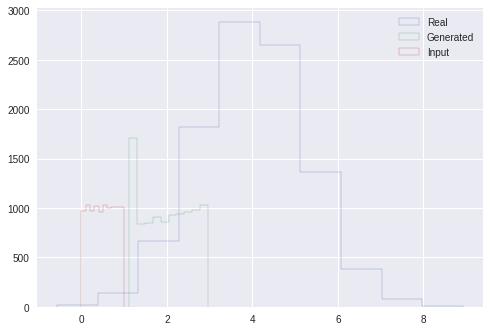

epoch: 29 // mu and std of Real: (4.003521302803085, 1.2407137484330368)
mu and std of Gen: (1.9909066, 0.57213056)


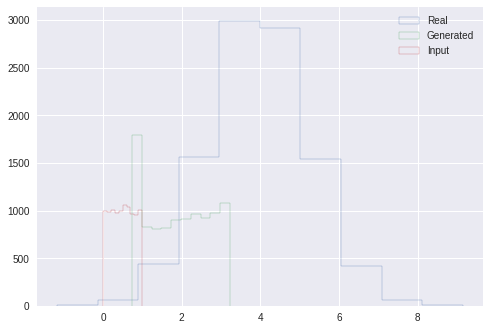

epoch: 39 // mu and std of Real: (3.9840772936345807, 1.2522576121463866)
mu and std of Gen: (1.9204631, 0.78962886)


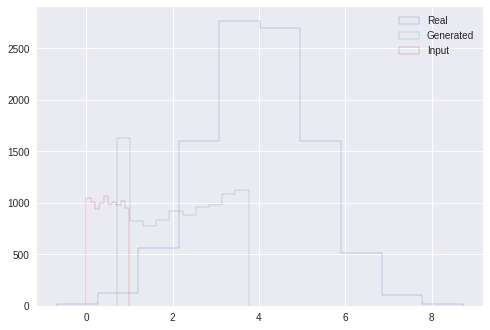

epoch: 49 // mu and std of Real: (3.998734237858888, 1.2582186794641166)
mu and std of Gen: (2.199057, 0.9636409)


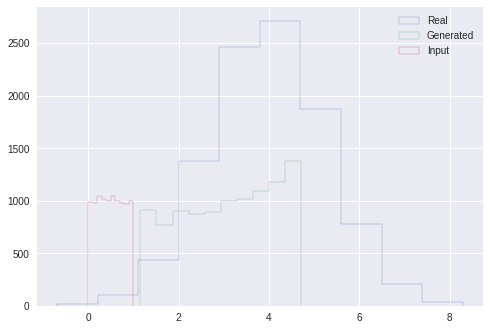

epoch: 59 // mu and std of Real: (3.9942861851920943, 1.259445566936619)
mu and std of Gen: (3.0834143, 1.0490304)


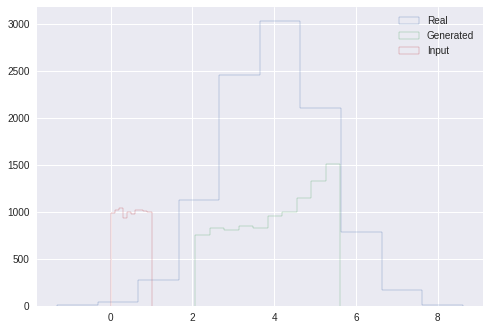

epoch: 69 // mu and std of Real: (4.000953429981471, 1.2648603720934055)
mu and std of Gen: (4.0652137, 1.0420783)


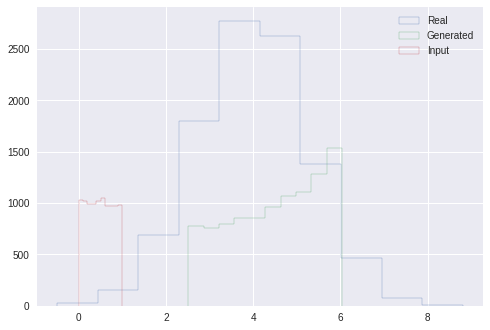

epoch: 79 // mu and std of Real: (4.005132507150095, 1.2577881454848592)
mu and std of Gen: (4.5044184, 1.030945)


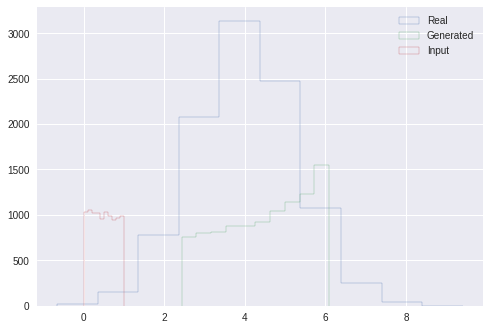

epoch: 89 // mu and std of Real: (4.00549436537399, 1.251472067981639)
mu and std of Gen: (4.491018, 1.0722923)


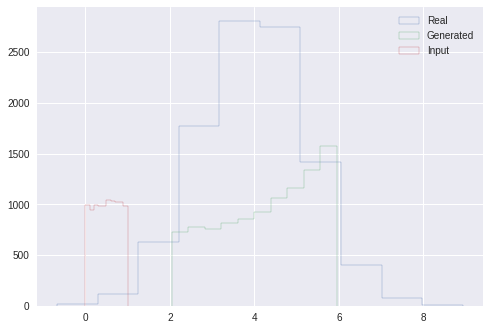

epoch: 99 // mu and std of Real: (4.001271726739112, 1.2485403504619832)
mu and std of Gen: (4.278145, 1.140768)


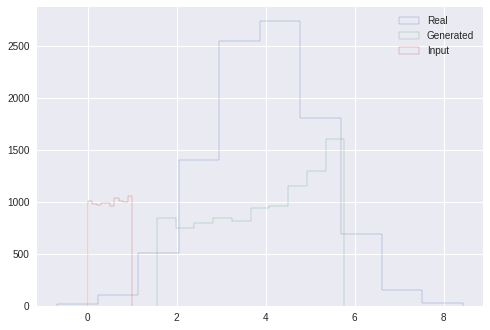

epoch: 109 // mu and std of Real: (4.003640342618805, 1.2557143253306182)
mu and std of Gen: (3.940098, 1.2542359)


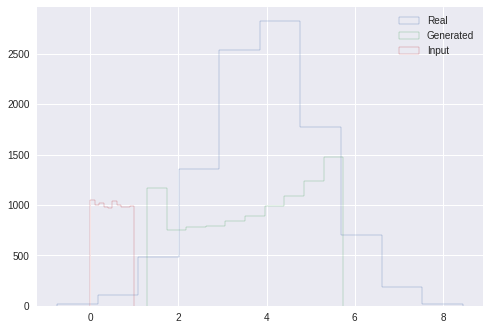

epoch: 119 // mu and std of Real: (4.00084107832006, 1.2688950499779115)
mu and std of Gen: (3.6958425, 1.3720056)


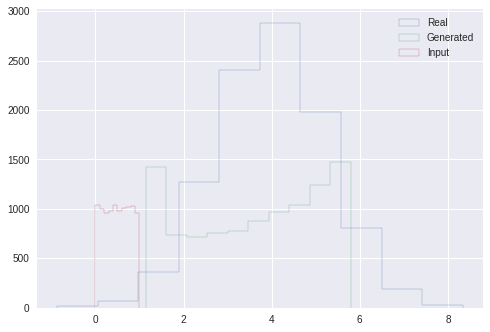

epoch: 129 // mu and std of Real: (4.001580238078867, 1.2451542057360265)
mu and std of Gen: (3.6050434, 1.4791)


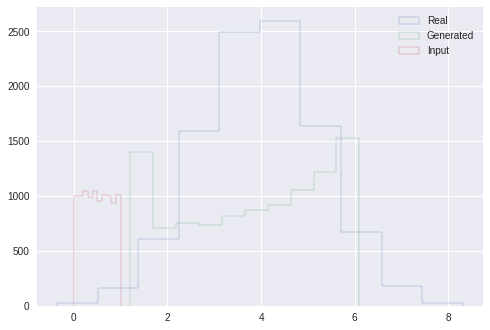

epoch: 139 // mu and std of Real: (4.0001813579849035, 1.2571641948691392)
mu and std of Gen: (3.8042867, 1.5623592)


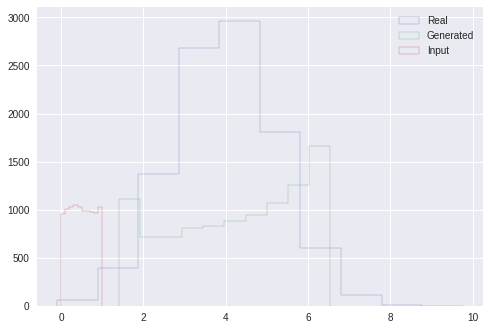

epoch: 149 // mu and std of Real: (3.9925026884701467, 1.250150674111845)
mu and std of Gen: (4.2437205, 1.587161)


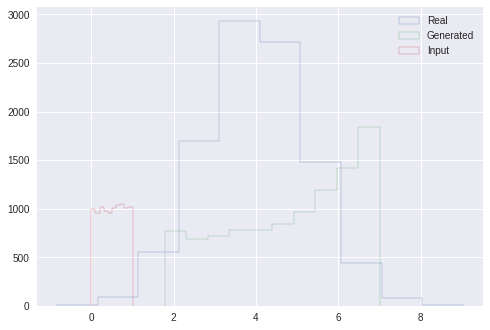

epoch: 159 // mu and std of Real: (4.021594161960299, 1.2578405860199684)
mu and std of Gen: (4.8662653, 1.5586653)


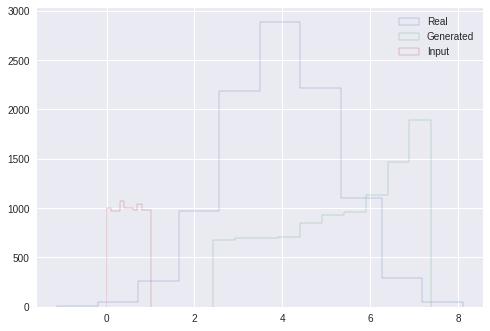

epoch: 169 // mu and std of Real: (3.9930375240570823, 1.2501428329323214)
mu and std of Gen: (5.3953195, 1.4587114)


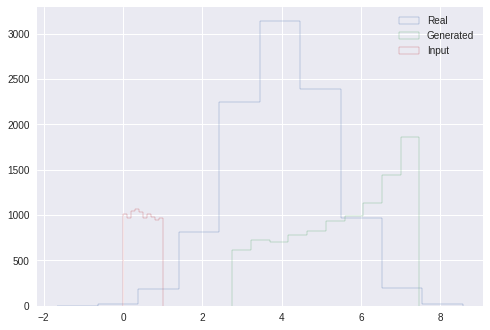

epoch: 179 // mu and std of Real: (4.0115642244589, 1.2610839321397487)
mu and std of Gen: (5.572548, 1.3726246)


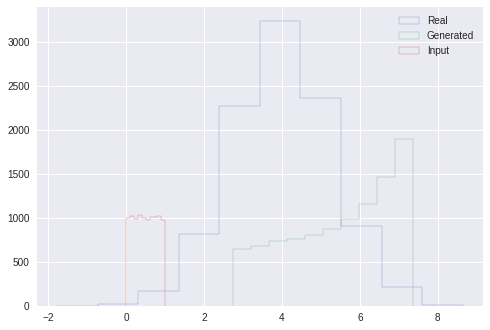

epoch: 189 // mu and std of Real: (3.990756442926917, 1.2549962046637106)
mu and std of Gen: (5.506999, 1.3553002)


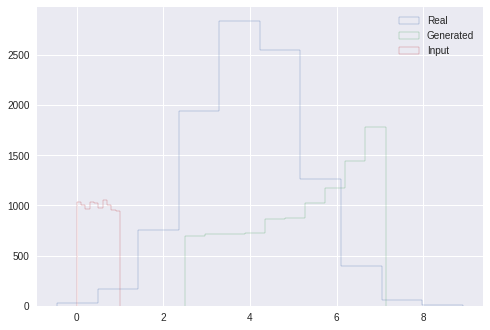

epoch: 199 // mu and std of Real: (3.996938636523297, 1.2508451191229981)
mu and std of Gen: (5.236651, 1.3578079)


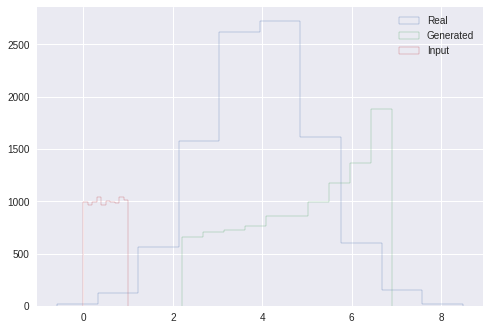

epoch: 209 // mu and std of Real: (3.9764367523412454, 1.253864958522669)
mu and std of Gen: (4.9951982, 1.3731909)


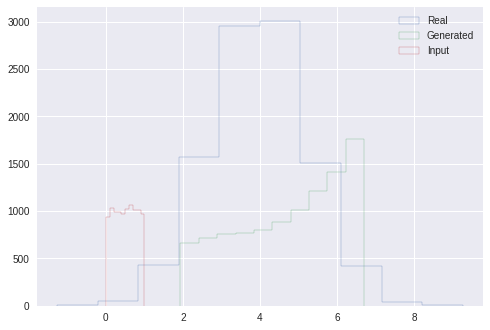

epoch: 219 // mu and std of Real: (3.987777246454062, 1.2588735917951086)
mu and std of Gen: (4.748531, 1.3938441)


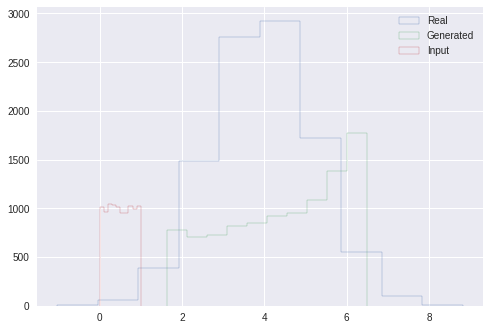

epoch: 229 // mu and std of Real: (3.996436839949044, 1.2407181478058356)
mu and std of Gen: (4.4631186, 1.439829)


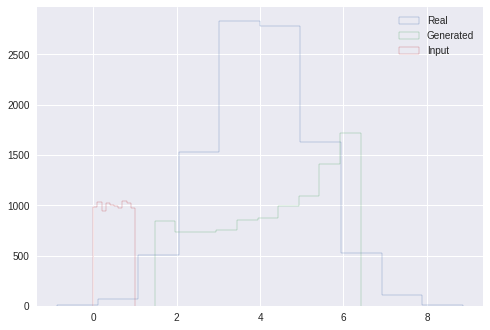

epoch: 239 // mu and std of Real: (4.020412521065641, 1.259412189139888)
mu and std of Gen: (4.316685, 1.4815178)


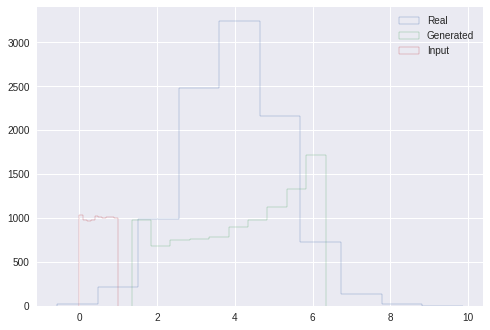

epoch: 249 // mu and std of Real: (4.007857793912809, 1.2554337914198572)
mu and std of Gen: (4.1855116, 1.5221219)


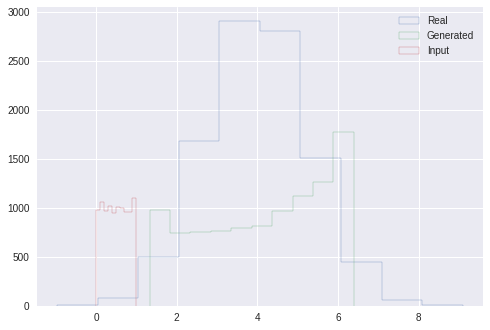

epoch: 259 // mu and std of Real: (4.0055661435826115, 1.264486188610878)
mu and std of Gen: (4.196652, 1.559829)


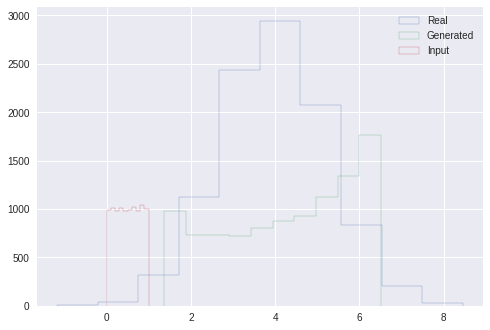

epoch: 269 // mu and std of Real: (3.987069141766325, 1.2649817963545138)
mu and std of Gen: (4.303943, 1.5810287)


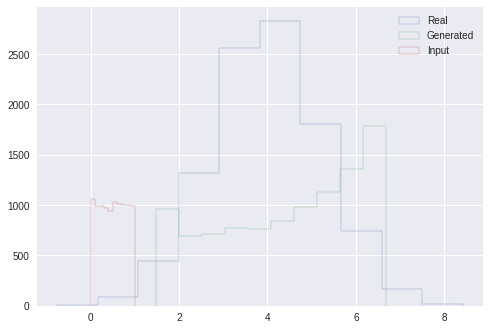

epoch: 279 // mu and std of Real: (4.006680084713381, 1.2451098694473506)
mu and std of Gen: (4.4637156, 1.5880849)


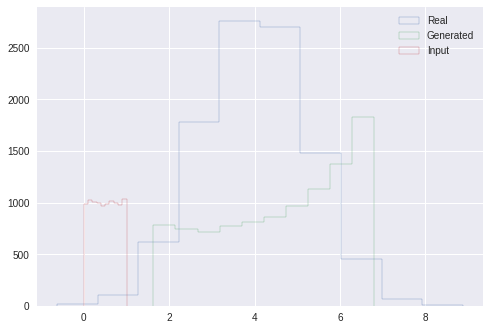

epoch: 289 // mu and std of Real: (4.025747860431132, 1.2477660361486453)
mu and std of Gen: (4.6507115, 1.550193)


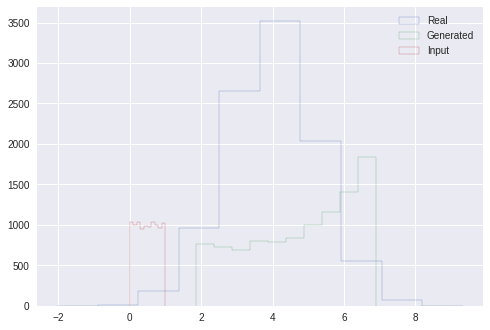

epoch: 299 // mu and std of Real: (4.005601585917006, 1.2575744749338194)
mu and std of Gen: (4.8251543, 1.5018957)


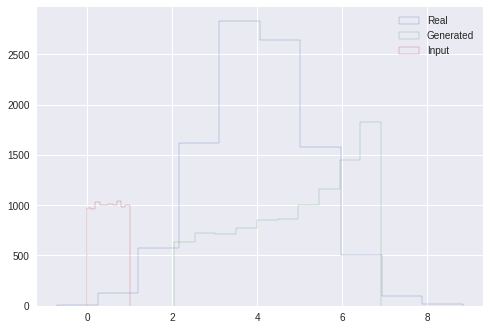

epoch: 309 // mu and std of Real: (4.026097248193112, 1.2723239816111065)
mu and std of Gen: (4.9384303, 1.4222966)


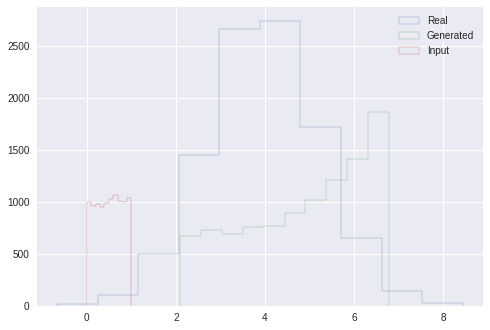

epoch: 319 // mu and std of Real: (3.9778701597217383, 1.2407107092192085)
mu and std of Gen: (4.8956227, 1.3794355)


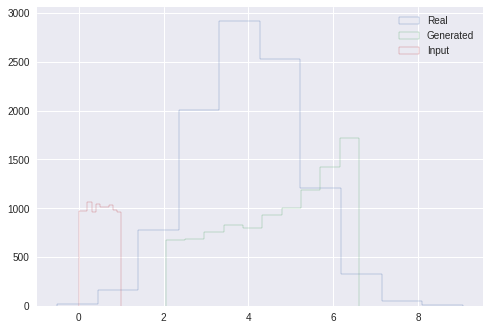

epoch: 329 // mu and std of Real: (3.983127938975749, 1.2478010156881687)
mu and std of Gen: (4.728635, 1.3286208)


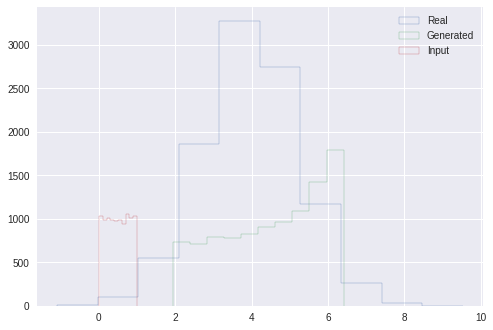

epoch: 339 // mu and std of Real: (3.9707104090742287, 1.2522360772586911)
mu and std of Gen: (4.5477524, 1.3251059)


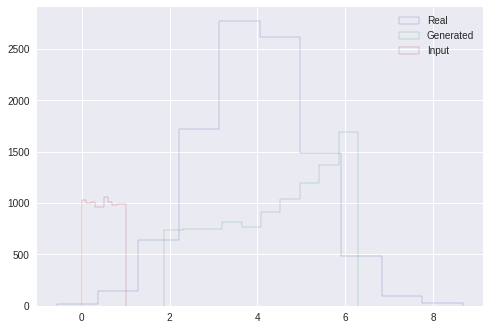

epoch: 349 // mu and std of Real: (3.9681291339077776, 1.25730368257429)
mu and std of Gen: (4.439283, 1.3004721)


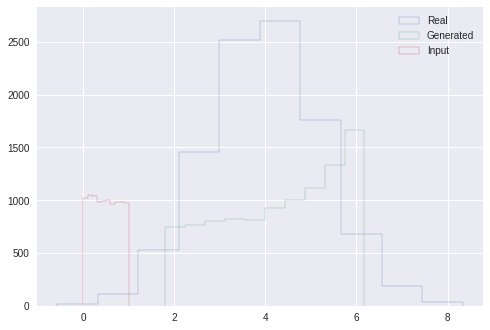

epoch: 359 // mu and std of Real: (3.995198951388232, 1.2568630838560284)
mu and std of Gen: (4.308798, 1.2891532)


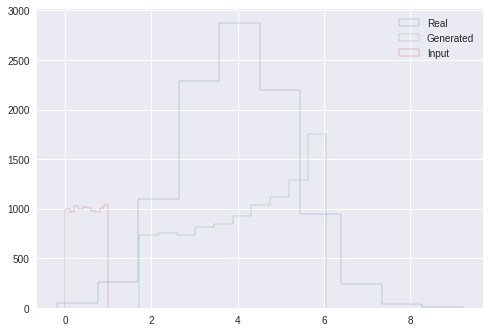

epoch: 369 // mu and std of Real: (3.999220046667561, 1.2570670357240985)
mu and std of Gen: (4.2272334, 1.2774155)


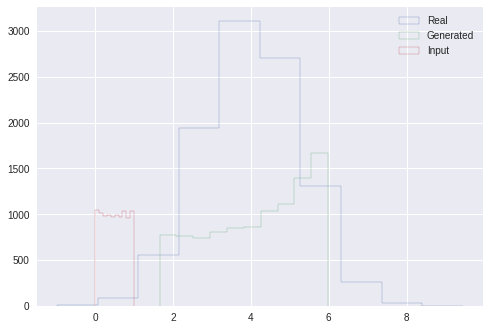

epoch: 379 // mu and std of Real: (4.01053191236097, 1.2461350603564516)
mu and std of Gen: (4.14725, 1.2823348)


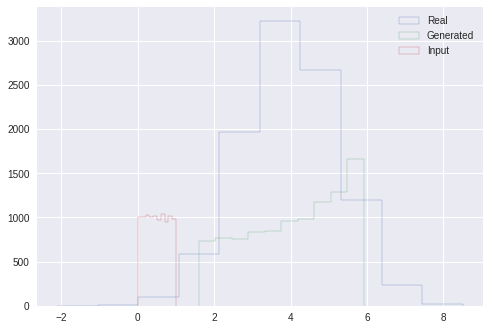

epoch: 389 // mu and std of Real: (3.9803516881647636, 1.253853604848528)
mu and std of Gen: (4.0736303, 1.2706014)


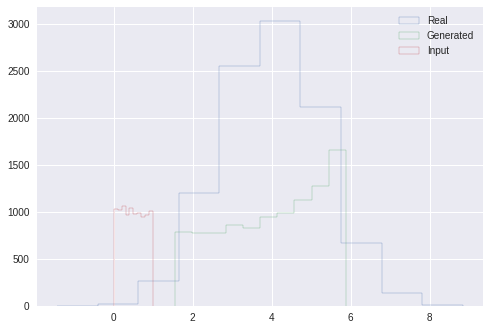

epoch: 399 // mu and std of Real: (4.013260645771875, 1.2631948132788549)
mu and std of Gen: (4.0087857, 1.2831731)


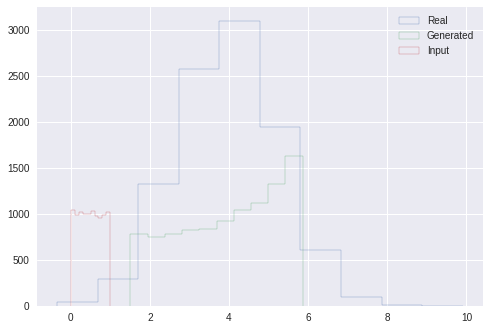

epoch: 409 // mu and std of Real: (3.982609146843929, 1.2608106046835565)
mu and std of Gen: (3.9973347, 1.2869197)


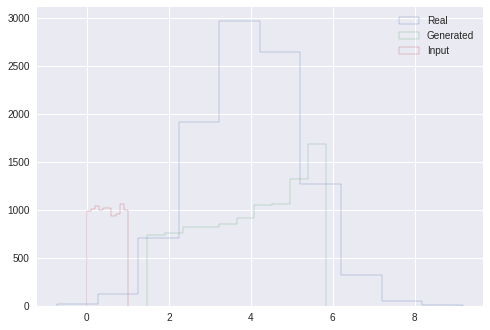

epoch: 419 // mu and std of Real: (3.9868772254407254, 1.2557297791269084)
mu and std of Gen: (3.9771278, 1.2916538)


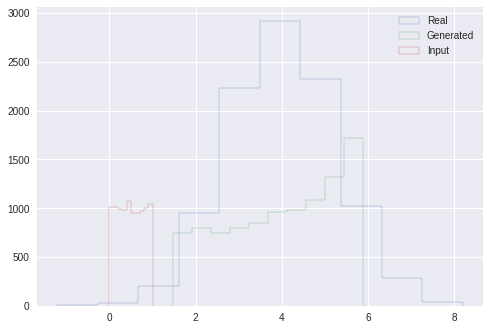

epoch: 429 // mu and std of Real: (4.00406888366199, 1.2354128543168235)
mu and std of Gen: (4.013811, 1.3055468)


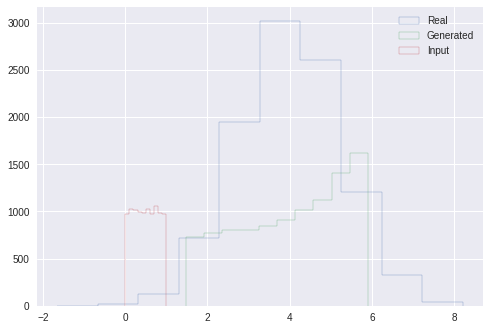

epoch: 439 // mu and std of Real: (4.000817553658212, 1.2475249793004213)
mu and std of Gen: (4.021532, 1.3012437)


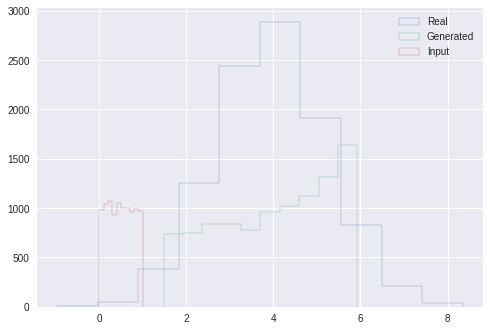

epoch: 449 // mu and std of Real: (3.975187858597785, 1.265341887212935)
mu and std of Gen: (4.0232406, 1.3076307)


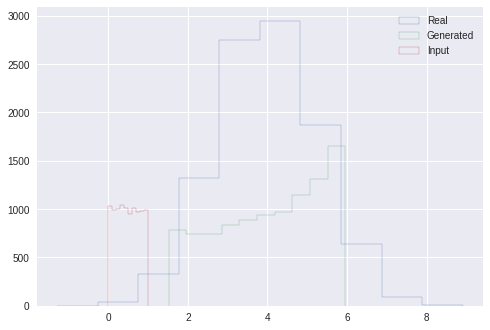

epoch: 459 // mu and std of Real: (4.006838369341827, 1.2598174718236756)
mu and std of Gen: (4.0616527, 1.3121022)


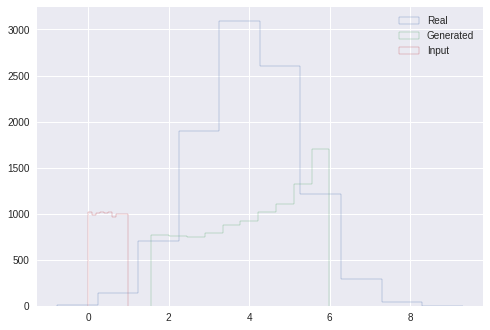

epoch: 469 // mu and std of Real: (3.9918519988662737, 1.2583175384950431)
mu and std of Gen: (4.112675, 1.3066725)


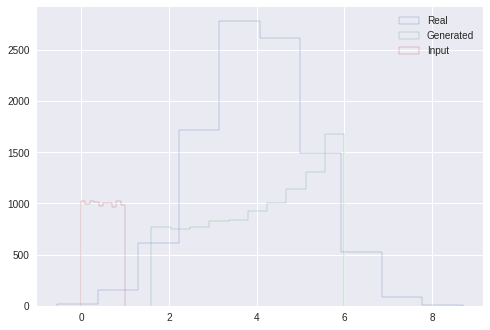

epoch: 479 // mu and std of Real: (3.9934680280575763, 1.2503442494455452)
mu and std of Gen: (4.1263127, 1.2945259)


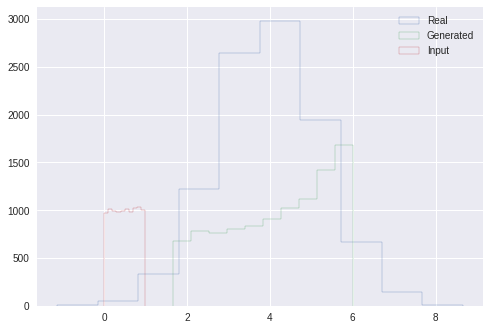

epoch: 489 // mu and std of Real: (4.000525705932057, 1.246247547784823)
mu and std of Gen: (4.1948013, 1.2755619)


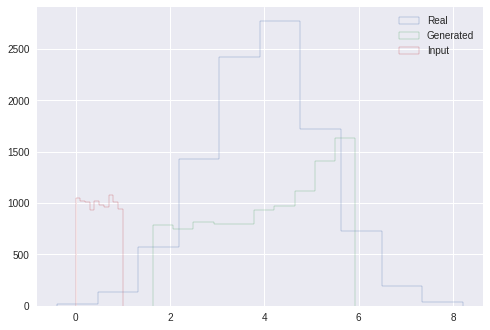

epoch: 499 // mu and std of Real: (4.02543052270644, 1.2369866954624438)
mu and std of Gen: (4.0972185, 1.268228)


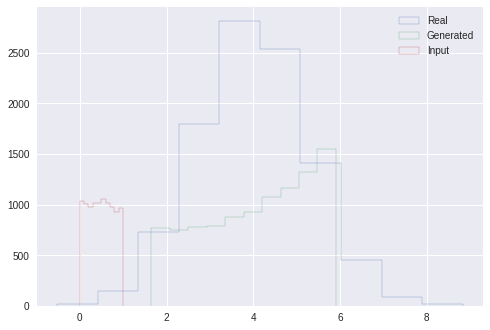

epoch: 509 // mu and std of Real: (4.000242018190382, 1.2650630445945514)
mu and std of Gen: (4.079146, 1.2463279)


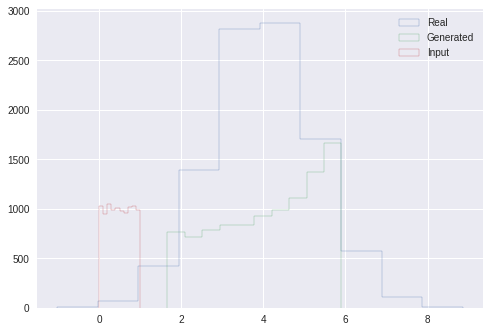

epoch: 519 // mu and std of Real: (4.014026867705394, 1.2547793759186279)
mu and std of Gen: (4.1006293, 1.2480441)


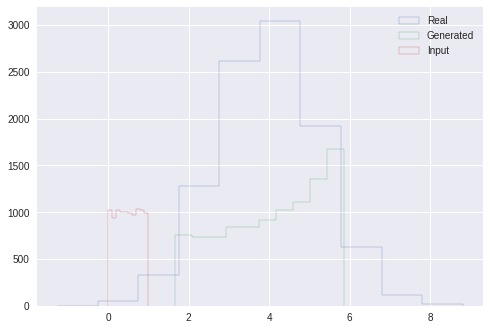

epoch: 529 // mu and std of Real: (3.9968734536277153, 1.2636014892639966)
mu and std of Gen: (4.0841312, 1.2342391)


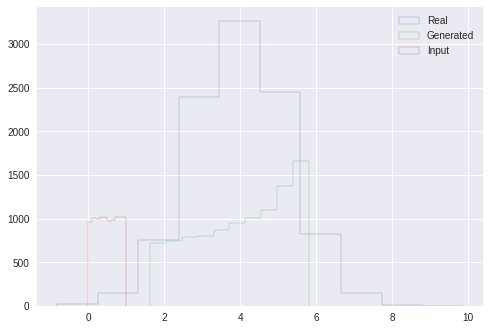

epoch: 539 // mu and std of Real: (4.006265432178556, 1.2410555995709909)
mu and std of Gen: (4.0380387, 1.2202321)


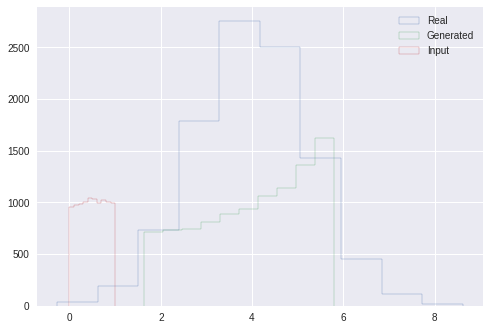

epoch: 549 // mu and std of Real: (4.0229219641933875, 1.2430554629024722)
mu and std of Gen: (4.0339103, 1.2072232)


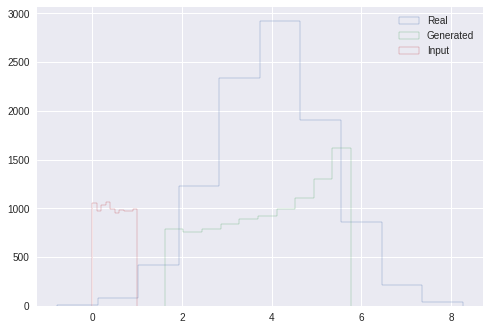

epoch: 559 // mu and std of Real: (4.013046909401438, 1.2473152706441435)
mu and std of Gen: (3.975264, 1.2274609)


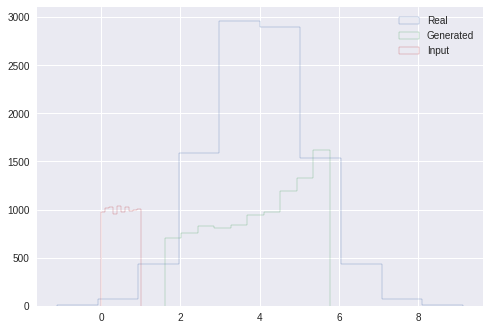

epoch: 569 // mu and std of Real: (3.996740256558472, 1.2572923553354889)
mu and std of Gen: (3.9949453, 1.2204543)


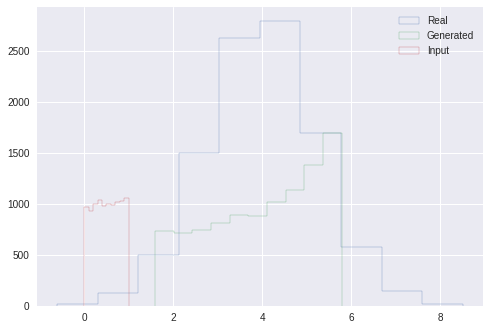

epoch: 579 // mu and std of Real: (4.010015576037209, 1.2435683053899385)
mu and std of Gen: (4.027536, 1.2308121)


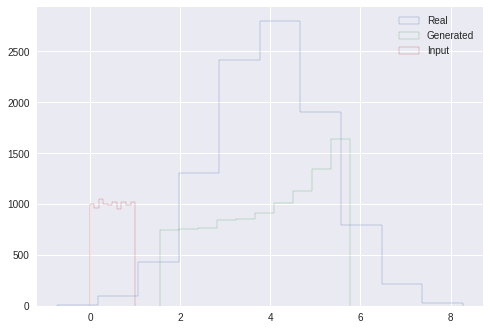

epoch: 589 // mu and std of Real: (3.996606902118464, 1.2526392762058607)
mu and std of Gen: (3.9733188, 1.2400151)


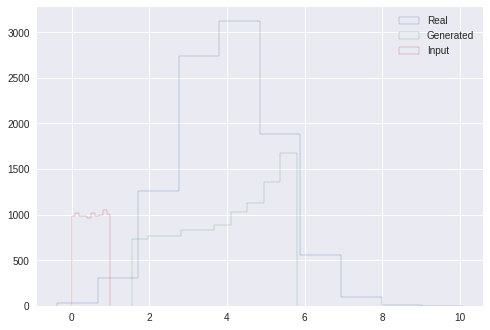

epoch: 599 // mu and std of Real: (4.013359635804501, 1.2529453523528946)
mu and std of Gen: (3.9992325, 1.2551398)


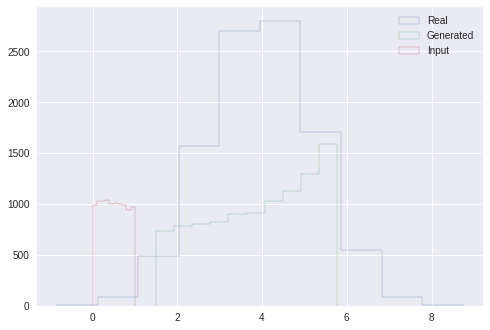

epoch: 609 // mu and std of Real: (3.986610378212556, 1.2472450983876417)
mu and std of Gen: (3.9286282, 1.253447)


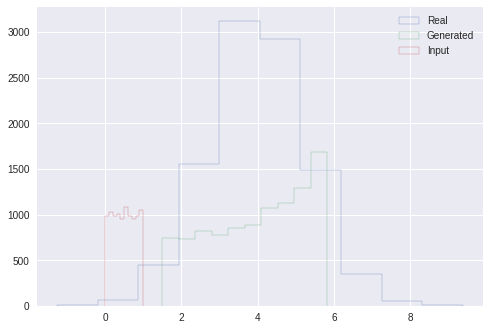

epoch: 619 // mu and std of Real: (4.005092377311614, 1.2559645772646704)
mu and std of Gen: (3.9861407, 1.2757595)


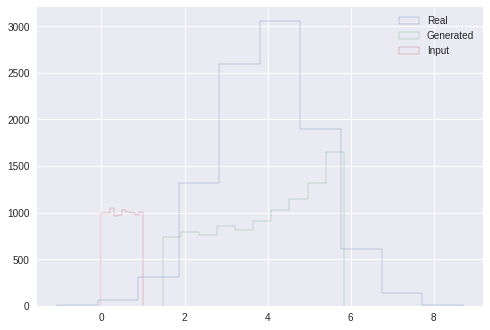

epoch: 629 // mu and std of Real: (4.028426536410701, 1.2371806559028533)
mu and std of Gen: (3.974609, 1.2864512)


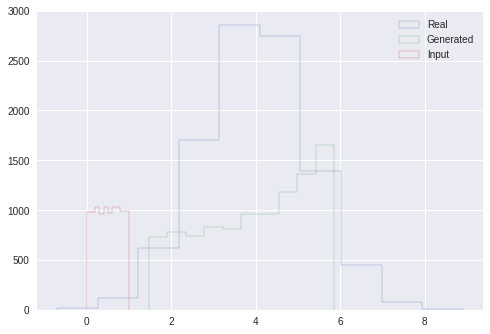

epoch: 639 // mu and std of Real: (3.992296842474613, 1.2555590524532108)
mu and std of Gen: (3.997388, 1.2920924)


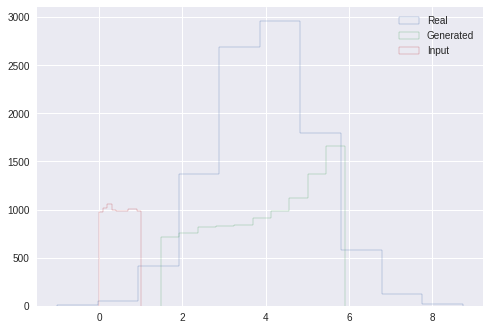

epoch: 649 // mu and std of Real: (4.000138084333294, 1.2442944695366371)
mu and std of Gen: (4.0172257, 1.2988791)


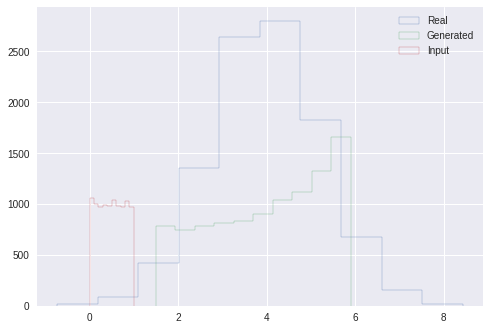

epoch: 659 // mu and std of Real: (4.00542541263145, 1.2293744967962985)
mu and std of Gen: (4.022596, 1.3063179)


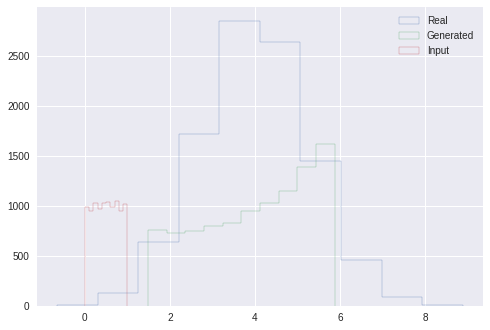

epoch: 669 // mu and std of Real: (4.007847650965041, 1.26166211260667)
mu and std of Gen: (4.0161967, 1.2870843)


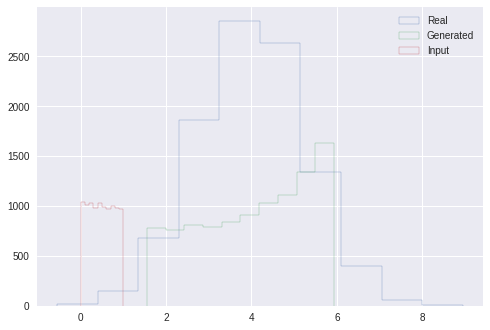

epoch: 679 // mu and std of Real: (4.012033594209138, 1.249182723656377)
mu and std of Gen: (4.051179, 1.2959827)


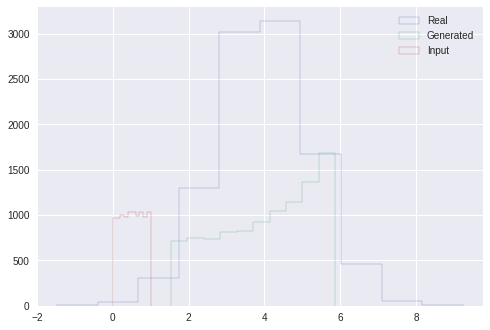

epoch: 689 // mu and std of Real: (3.9983519528744007, 1.2430352638507014)
mu and std of Gen: (4.0499673, 1.26701)


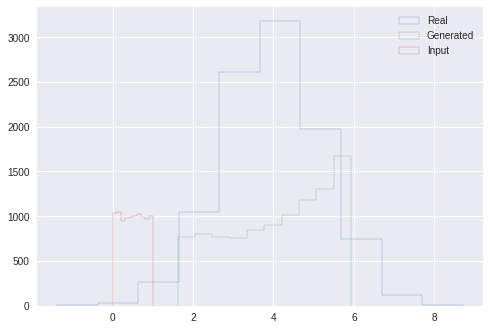

epoch: 699 // mu and std of Real: (3.9821790666598558, 1.2390094710402277)
mu and std of Gen: (4.0872545, 1.2777342)


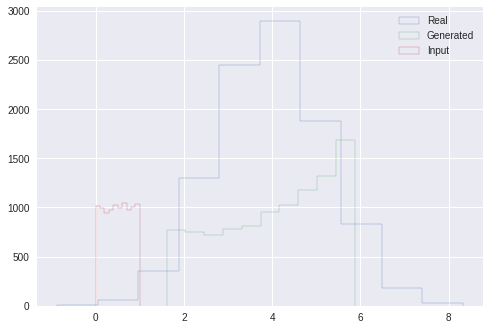

epoch: 709 // mu and std of Real: (3.9771390913974263, 1.237295532053859)
mu and std of Gen: (4.0706315, 1.2541548)


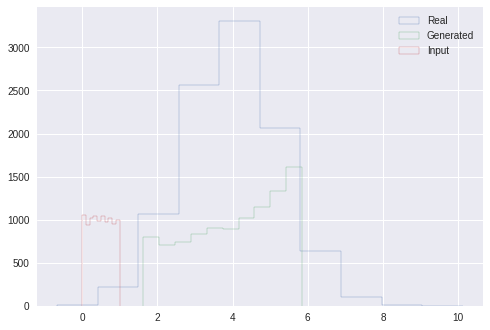

epoch: 719 // mu and std of Real: (4.002744202383566, 1.2572655497792482)
mu and std of Gen: (4.0411534, 1.2353872)


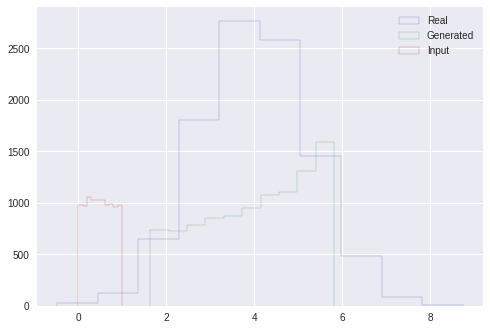

epoch: 729 // mu and std of Real: (4.019990153616234, 1.2410529108113704)
mu and std of Gen: (4.031491, 1.2163831)


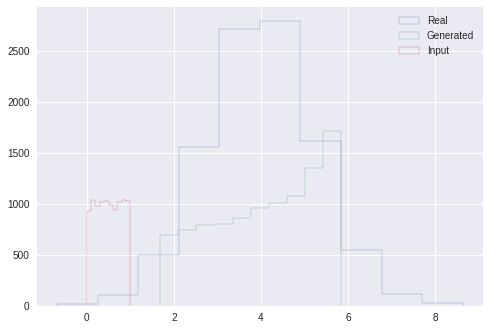

epoch: 739 // mu and std of Real: (4.004613990043048, 1.2506032639150777)
mu and std of Gen: (4.092601, 1.2169472)


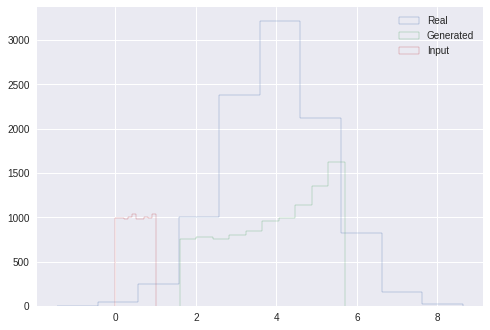

epoch: 749 // mu and std of Real: (3.998598195919081, 1.2573264728759423)
mu and std of Gen: (3.9536898, 1.2080076)


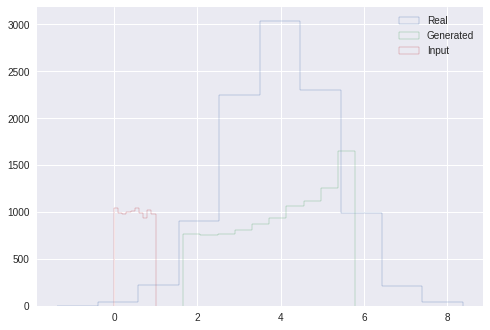

epoch: 759 // mu and std of Real: (4.006546138433632, 1.2510677350901627)
mu and std of Gen: (4.019894, 1.2156101)


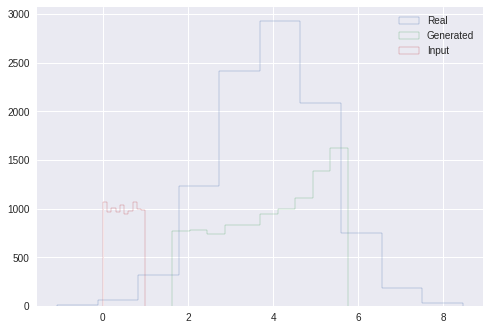

epoch: 769 // mu and std of Real: (3.984400231938444, 1.2562366320108278)
mu and std of Gen: (3.9883816, 1.2201157)


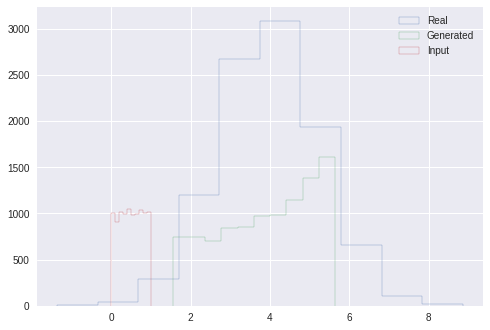

epoch: 779 // mu and std of Real: (4.007753471436317, 1.261390564862773)
mu and std of Gen: (3.9074867, 1.1955135)


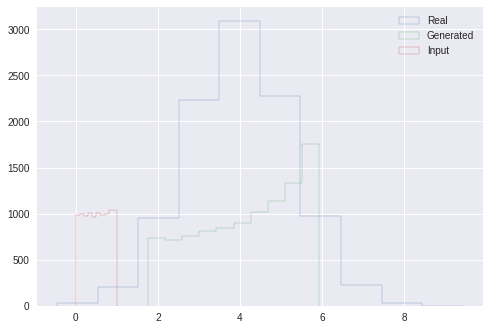

epoch: 789 // mu and std of Real: (4.008837938262097, 1.2598872047591805)
mu and std of Gen: (4.1827283, 1.2304888)


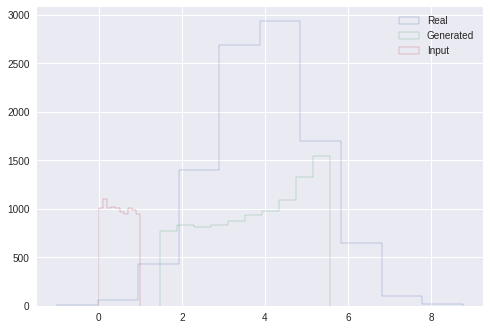

epoch: 799 // mu and std of Real: (4.000323412487305, 1.262611121707154)
mu and std of Gen: (3.7775605, 1.2047722)


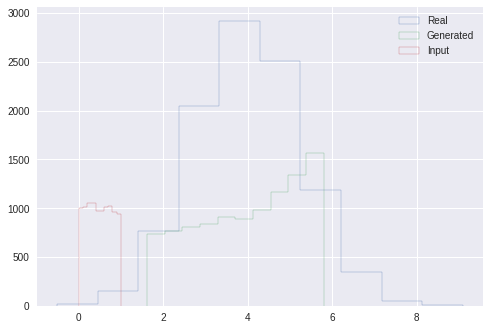

epoch: 809 // mu and std of Real: (4.008138540654307, 1.2435969976823593)
mu and std of Gen: (3.9954262, 1.2266109)


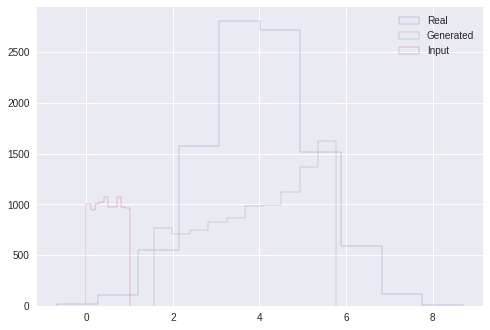

epoch: 819 // mu and std of Real: (4.007313028327676, 1.2523962058944056)
mu and std of Gen: (3.976729, 1.228957)


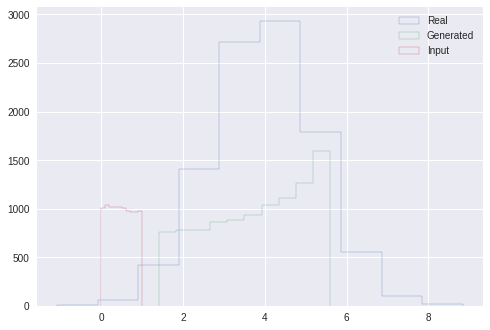

epoch: 829 // mu and std of Real: (4.007073009999966, 1.2531827714696975)
mu and std of Gen: (3.780638, 1.2304966)


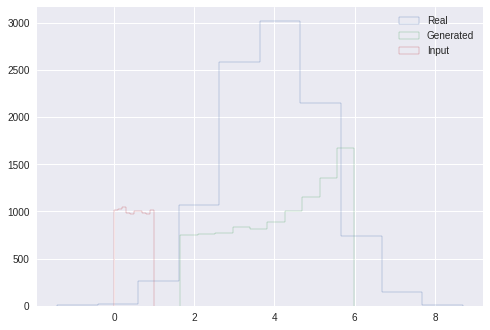

epoch: 839 // mu and std of Real: (3.99564868131733, 1.2476549132516561)
mu and std of Gen: (4.153747, 1.2814335)


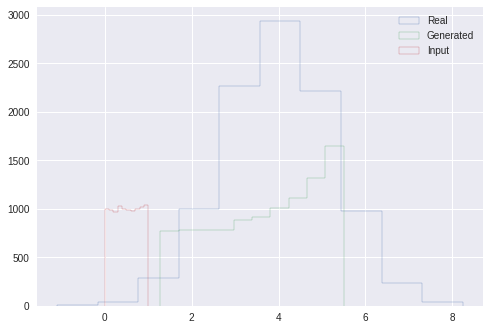

epoch: 849 // mu and std of Real: (4.004243094293474, 1.2423411571319627)
mu and std of Gen: (3.6902206, 1.2448307)


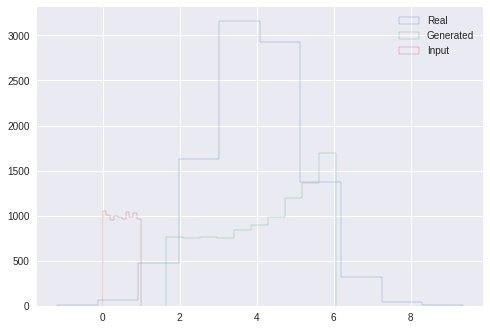

epoch: 859 // mu and std of Real: (3.9858574545222165, 1.246237151676606)
mu and std of Gen: (4.2093205, 1.304742)


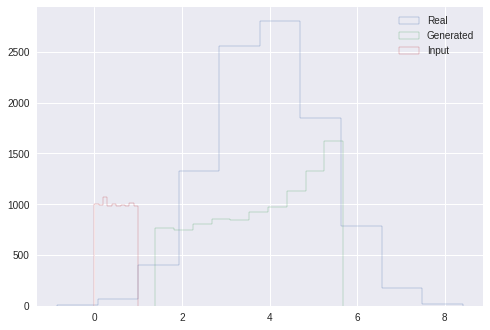

epoch: 869 // mu and std of Real: (3.9935111217626384, 1.245586446525165)
mu and std of Gen: (3.8381233, 1.2623409)


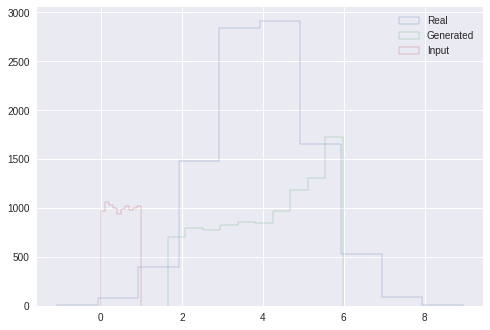

epoch: 879 // mu and std of Real: (3.9961645578559457, 1.2681111386240593)
mu and std of Gen: (4.1486783, 1.2742842)


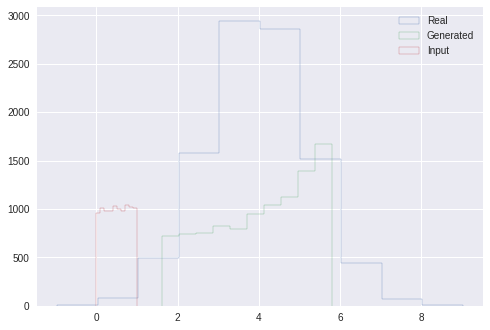

epoch: 889 // mu and std of Real: (4.000099509873788, 1.2487751254307098)
mu and std of Gen: (4.0465417, 1.2283616)


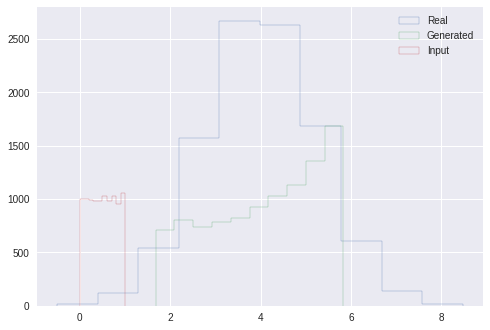

epoch: 899 // mu and std of Real: (4.014145031831143, 1.2364254347122776)
mu and std of Gen: (4.079083, 1.222975)


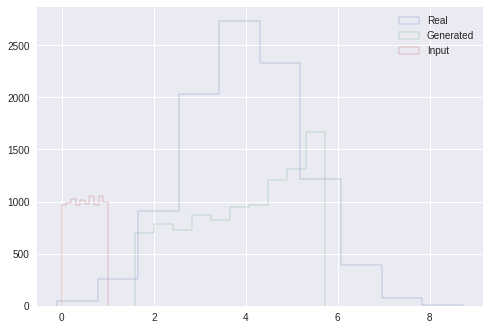

epoch: 909 // mu and std of Real: (3.993818478671355, 1.2393495490682391)
mu and std of Gen: (3.969782, 1.2093868)


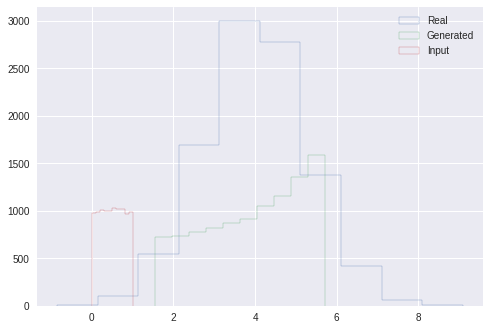

epoch: 919 // mu and std of Real: (4.014107455428296, 1.2562609449287947)
mu and std of Gen: (3.9456425, 1.2213604)


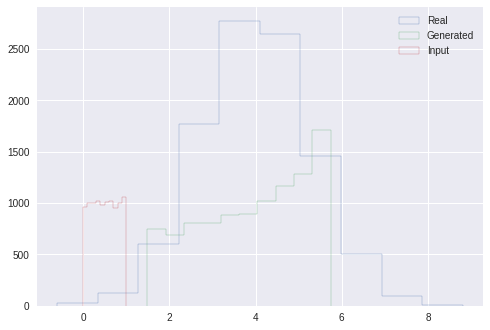

epoch: 929 // mu and std of Real: (4.003375950356941, 1.2584826175237849)
mu and std of Gen: (3.9476454, 1.2497319)


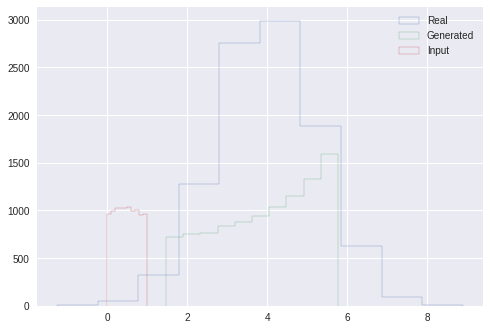

epoch: 939 // mu and std of Real: (4.014496894949202, 1.2531996165912416)
mu and std of Gen: (3.9380257, 1.2518132)


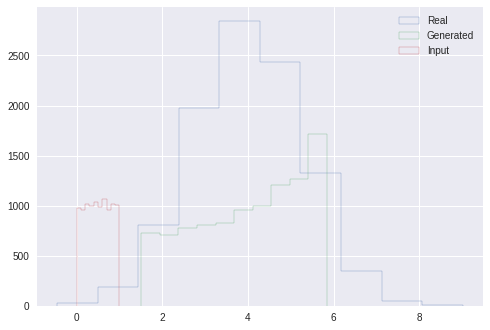

epoch: 949 // mu and std of Real: (4.0098952148554, 1.26088060514786)
mu and std of Gen: (4.019312, 1.2686597)


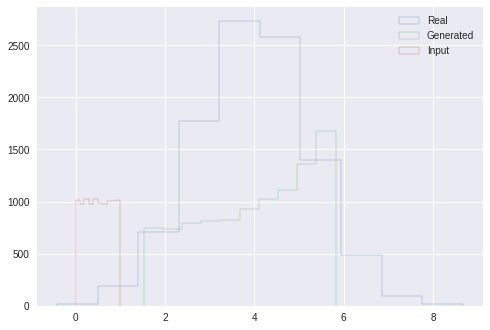

epoch: 959 // mu and std of Real: (3.983600537884926, 1.255500085255403)
mu and std of Gen: (3.9974859, 1.2654371)


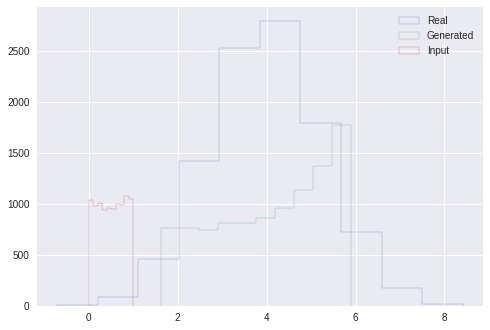

epoch: 969 // mu and std of Real: (4.001701531446075, 1.2406410130133778)
mu and std of Gen: (4.103412, 1.2760236)


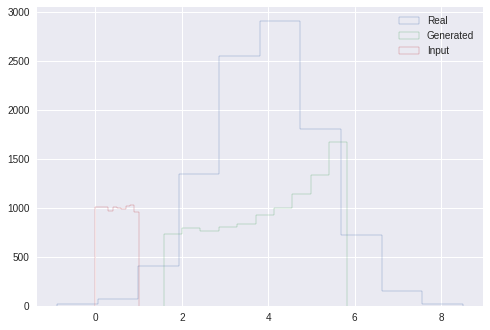

epoch: 979 // mu and std of Real: (3.9853325017824224, 1.254768012680372)
mu and std of Gen: (4.024156, 1.2497977)


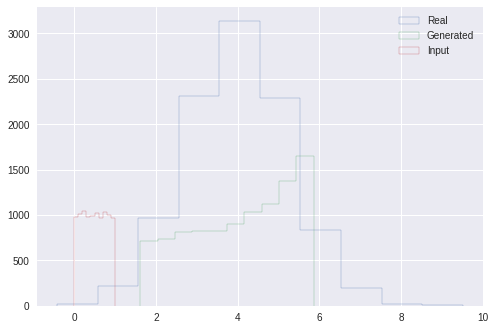

epoch: 989 // mu and std of Real: (4.013213165893032, 1.2388464835279933)
mu and std of Gen: (4.0620313, 1.2408954)


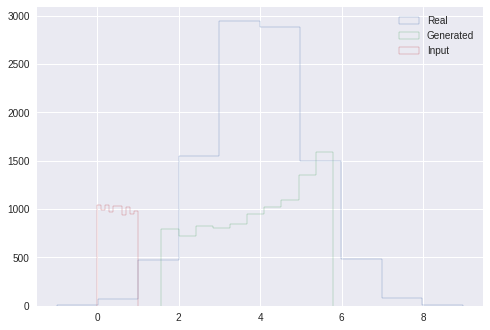

epoch: 999 // mu and std of Real: (3.9828835917644487, 1.2422321618945777)
mu and std of Gen: (3.9748008, 1.2384068)


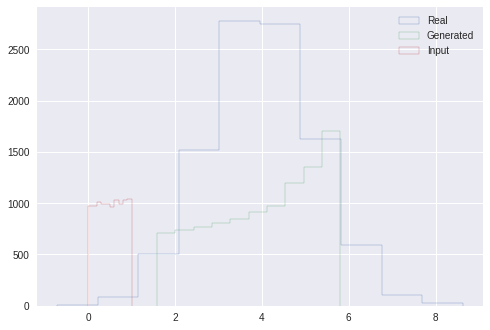

epoch: 1009 // mu and std of Real: (3.9972990501921157, 1.2360946540204465)
mu and std of Gen: (4.0346313, 1.2405523)


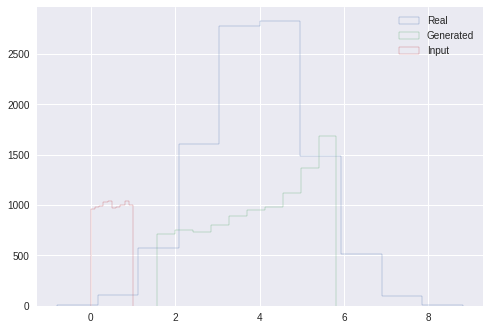

epoch: 1019 // mu and std of Real: (3.980859985750186, 1.2537818469738282)
mu and std of Gen: (4.038156, 1.2409197)


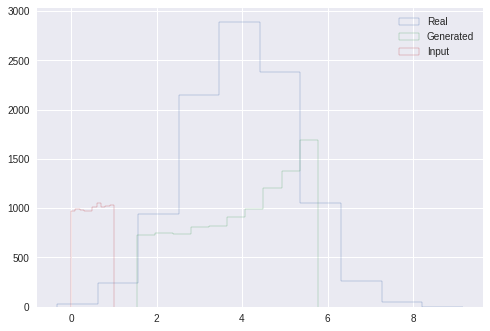

epoch: 1029 // mu and std of Real: (4.001142810509962, 1.2589419133273367)
mu and std of Gen: (3.9965715, 1.2467923)


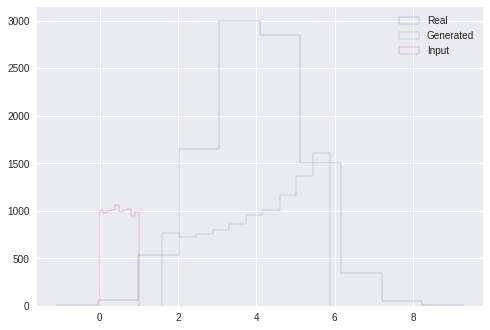

epoch: 1039 // mu and std of Real: (4.005449561631394, 1.2619272503771064)
mu and std of Gen: (4.059891, 1.2492428)


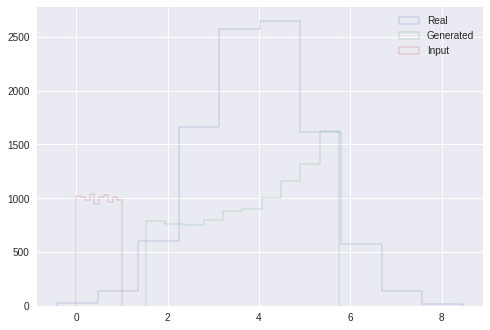

epoch: 1049 // mu and std of Real: (4.009157396373992, 1.237751644111)
mu and std of Gen: (3.9434216, 1.2523133)


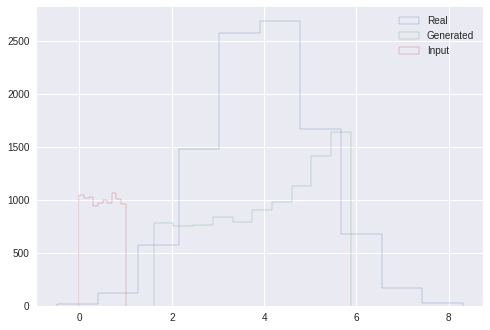

epoch: 1059 // mu and std of Real: (3.9834825893479406, 1.2348497145400128)
mu and std of Gen: (4.059883, 1.2654274)


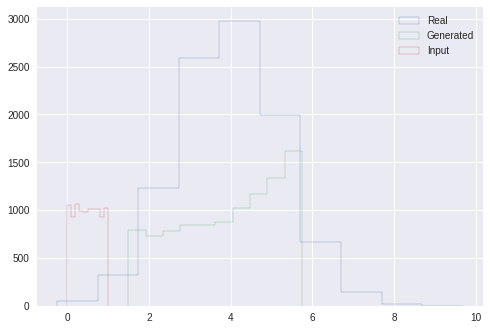

epoch: 1069 // mu and std of Real: (3.982873683671269, 1.261153607785394)
mu and std of Gen: (3.9279723, 1.2562094)


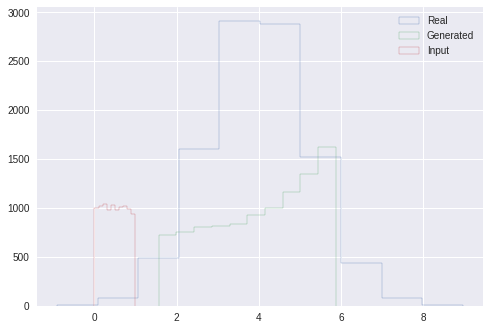

epoch: 1079 // mu and std of Real: (4.003207305891813, 1.2374126772918734)
mu and std of Gen: (4.0393944, 1.2618829)


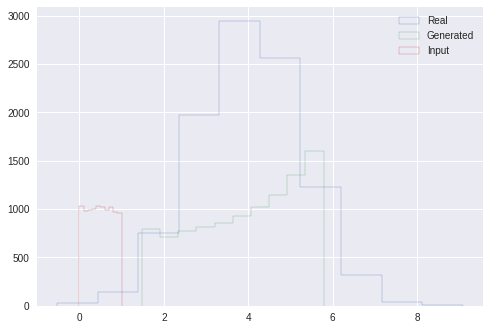

epoch: 1089 // mu and std of Real: (4.0069918790351915, 1.2462763986305874)
mu and std of Gen: (3.9485207, 1.2658054)


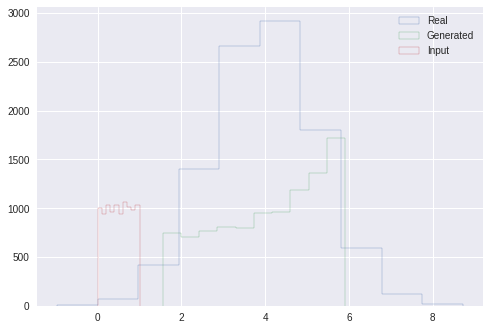

epoch: 1099 // mu and std of Real: (4.0093888432444, 1.250416719855083)
mu and std of Gen: (4.085834, 1.2843807)


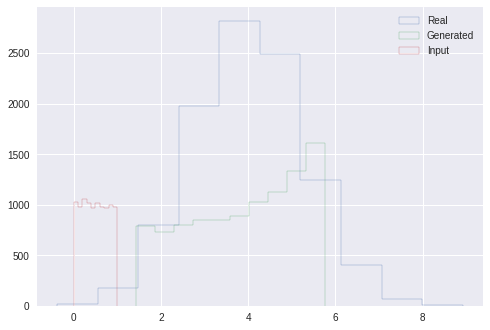

epoch: 1109 // mu and std of Real: (4.018461842011136, 1.253409803534127)
mu and std of Gen: (3.8960207, 1.2733473)


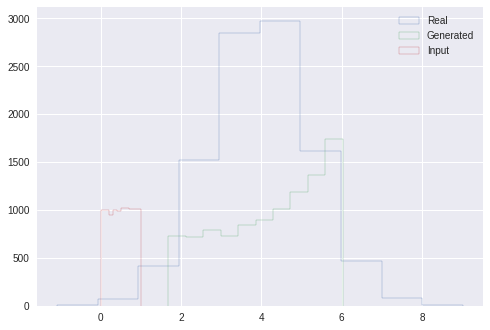

epoch: 1119 // mu and std of Real: (3.994985955504796, 1.2547350210477954)
mu and std of Gen: (4.216407, 1.2778593)


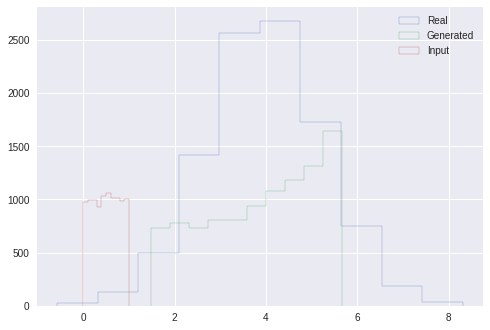

epoch: 1129 // mu and std of Real: (3.999609445714798, 1.2568086593861376)
mu and std of Gen: (3.8989813, 1.2298576)


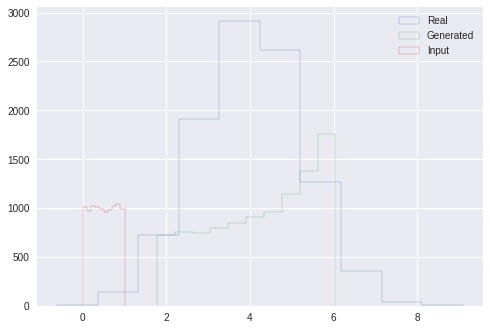

epoch: 1139 // mu and std of Real: (4.001078658508141, 1.2499530128855205)
mu and std of Gen: (4.259475, 1.2608519)


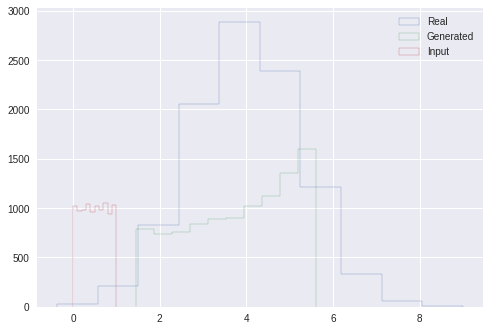

epoch: 1149 // mu and std of Real: (3.99537778259861, 1.2495374333748257)
mu and std of Gen: (3.826091, 1.2206192)


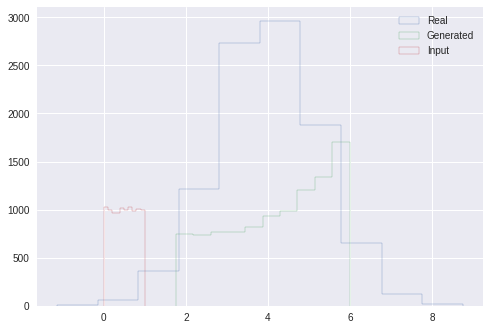

epoch: 1159 // mu and std of Real: (4.012791694339809, 1.2552828153481255)
mu and std of Gen: (4.211969, 1.2458895)


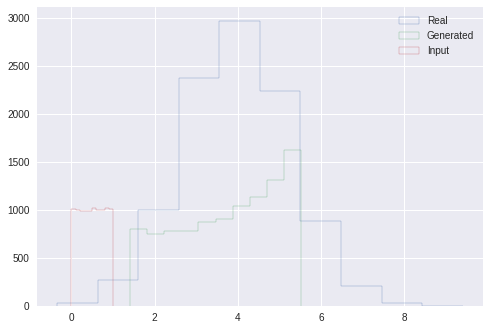

epoch: 1169 // mu and std of Real: (3.9924000765386496, 1.258459584301948)
mu and std of Gen: (3.7553167, 1.212447)


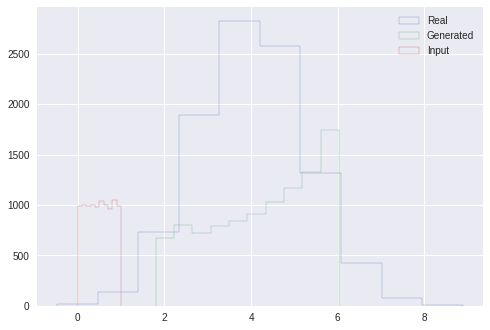

epoch: 1179 // mu and std of Real: (4.016951578849336, 1.2413479886275187)
mu and std of Gen: (4.2665396, 1.2390276)


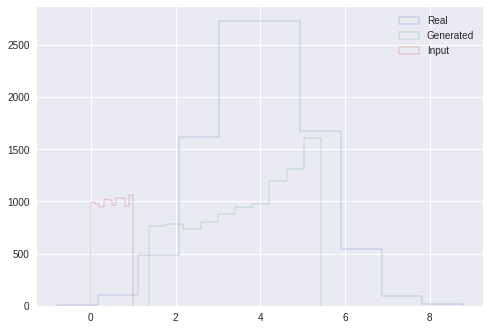

epoch: 1189 // mu and std of Real: (4.004583826795151, 1.26265350299361)
mu and std of Gen: (3.6955817, 1.1961778)


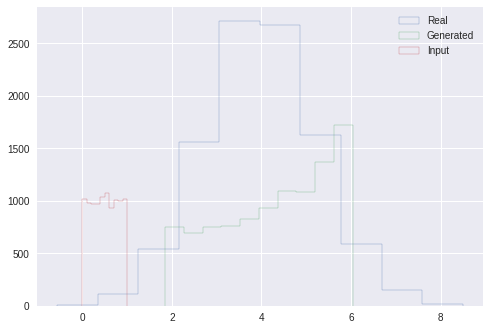

epoch: 1199 // mu and std of Real: (3.9949554242503282, 1.23998511194518)
mu and std of Gen: (4.290588, 1.2305676)


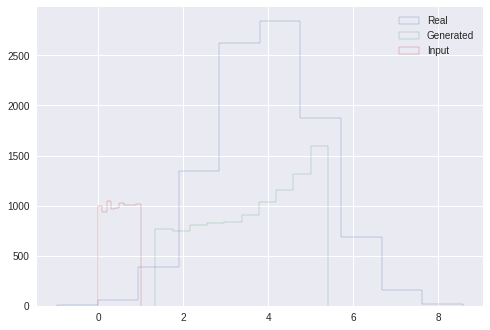

epoch: 1209 // mu and std of Real: (3.9984771093179434, 1.255555115485763)
mu and std of Gen: (3.6569462, 1.191419)


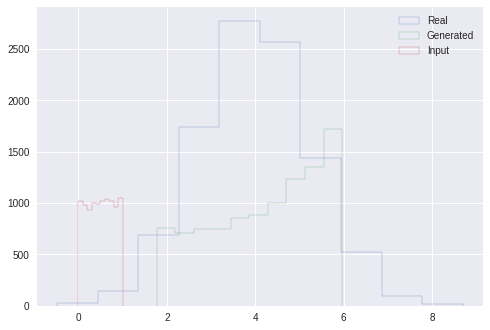

epoch: 1219 // mu and std of Real: (3.9938355776450916, 1.2534535127567923)
mu and std of Gen: (4.213188, 1.2316319)


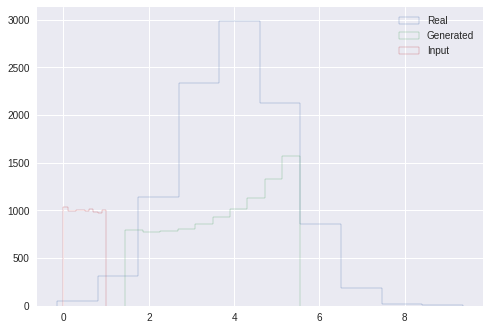

epoch: 1229 // mu and std of Real: (4.006669272594552, 1.2473258035583197)
mu and std of Gen: (3.7702446, 1.2079647)


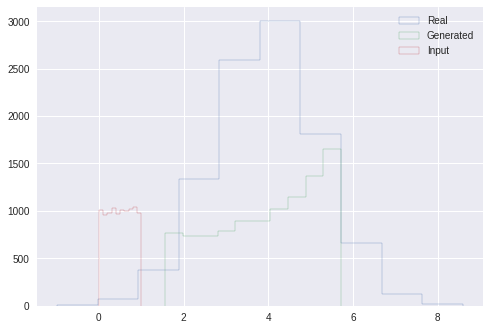

epoch: 1239 // mu and std of Real: (3.977744036155188, 1.2389180064352523)
mu and std of Gen: (3.952218, 1.215591)


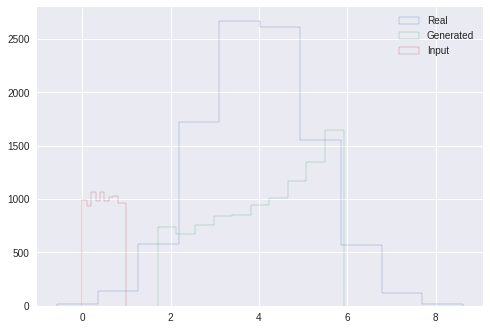

epoch: 1249 // mu and std of Real: (3.987001629999678, 1.261770971301848)
mu and std of Gen: (4.1414638, 1.2243897)


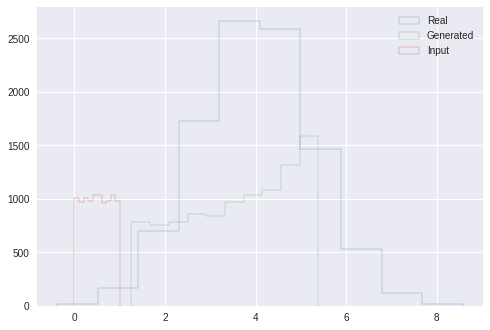

epoch: 1259 // mu and std of Real: (4.004423310216897, 1.2530690887909546)
mu and std of Gen: (3.600955, 1.2166256)


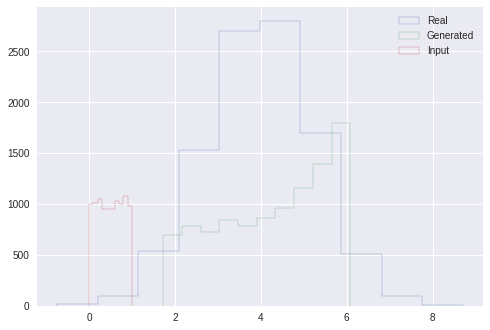

epoch: 1269 // mu and std of Real: (3.998923940520073, 1.241346941358429)
mu and std of Gen: (4.271989, 1.2879031)


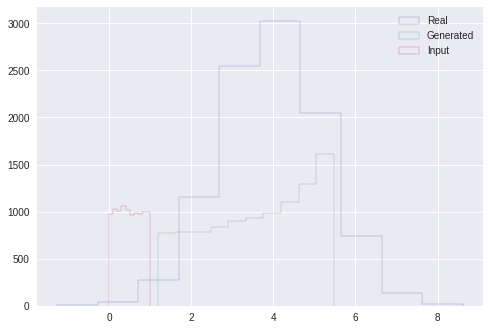

epoch: 1279 // mu and std of Real: (3.9833326940993743, 1.2432273044360456)
mu and std of Gen: (3.614494, 1.261392)


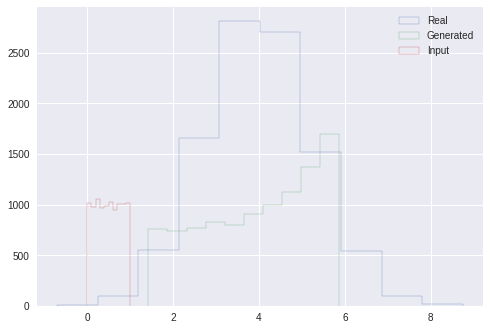

epoch: 1289 // mu and std of Real: (3.994623441652843, 1.243872517213602)
mu and std of Gen: (3.9861457, 1.313001)


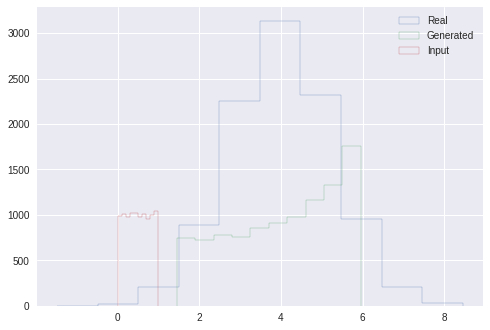

epoch: 1299 // mu and std of Real: (4.001051040833456, 1.2459817598213905)
mu and std of Gen: (4.068854, 1.328351)


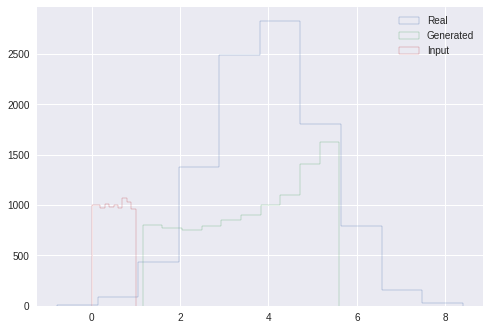

epoch: 1309 // mu and std of Real: (3.9981420659263196, 1.2545695851401975)
mu and std of Gen: (3.697089, 1.3194991)


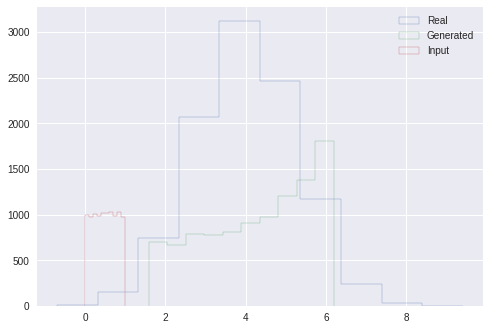

epoch: 1319 // mu and std of Real: (4.013638112700677, 1.2512873692077537)
mu and std of Gen: (4.300087, 1.3510195)


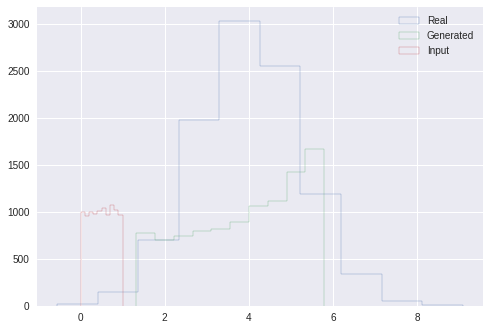

epoch: 1329 // mu and std of Real: (4.002562355044102, 1.2365790875170988)
mu and std of Gen: (3.9138532, 1.3126271)


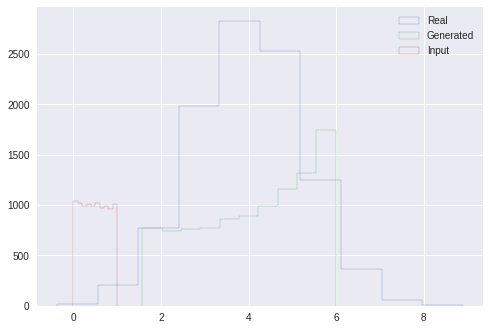

epoch: 1339 // mu and std of Real: (3.995344876742496, 1.2347200815867447)
mu and std of Gen: (4.125949, 1.3057605)


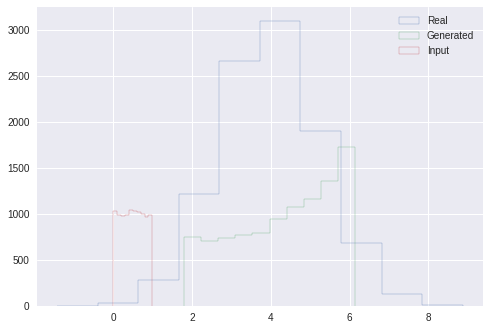

epoch: 1349 // mu and std of Real: (3.9925286056957447, 1.2620867305422225)
mu and std of Gen: (4.3368087, 1.2720683)


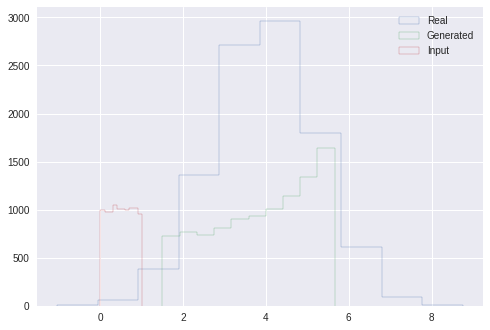

epoch: 1359 // mu and std of Real: (3.9966421615498358, 1.24272414641487)
mu and std of Gen: (3.8913028, 1.2158058)


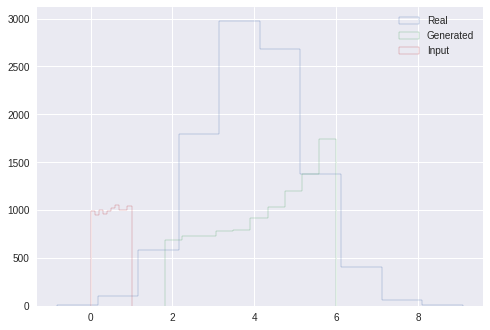

epoch: 1369 // mu and std of Real: (3.995499052872754, 1.2548160984608345)
mu and std of Gen: (4.2694345, 1.2202665)


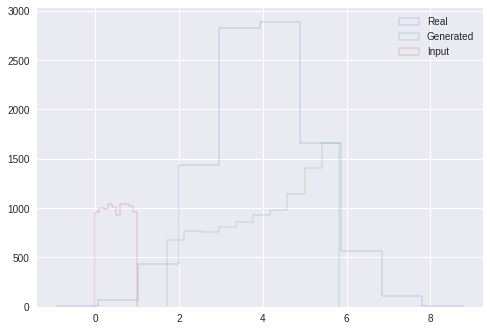

epoch: 1379 // mu and std of Real: (4.014321518487283, 1.2370069715931526)
mu and std of Gen: (4.096438, 1.199224)


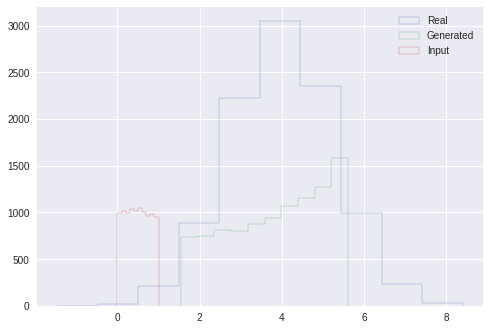

epoch: 1389 // mu and std of Real: (4.000604600673001, 1.2517683072067916)
mu and std of Gen: (3.863137, 1.1855055)


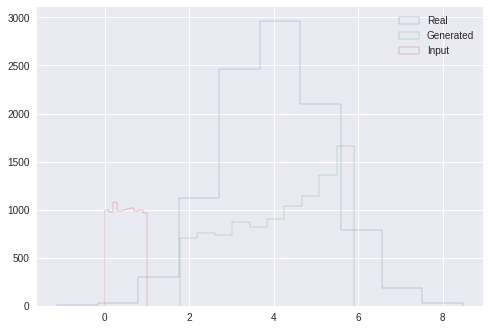

epoch: 1399 // mu and std of Real: (4.013441836653532, 1.2429532067682543)
mu and std of Gen: (4.16717, 1.2107867)


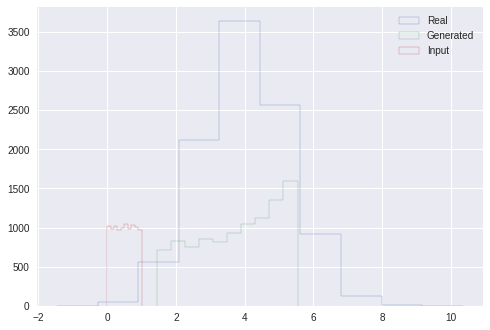

epoch: 1409 // mu and std of Real: (4.015515329978631, 1.2650092499267818)
mu and std of Gen: (3.7905028, 1.1988971)


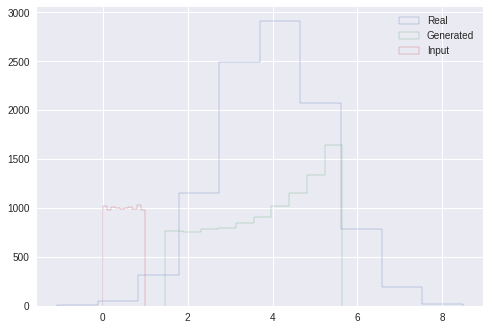

epoch: 1419 // mu and std of Real: (4.025181391942926, 1.251835886212489)
mu and std of Gen: (3.8641648, 1.2298808)


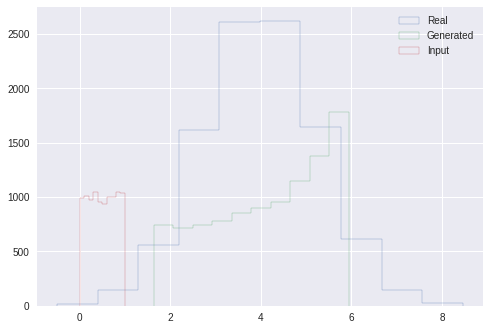

epoch: 1429 // mu and std of Real: (3.9926331512507867, 1.2517518602580058)
mu and std of Gen: (4.152424, 1.2723703)


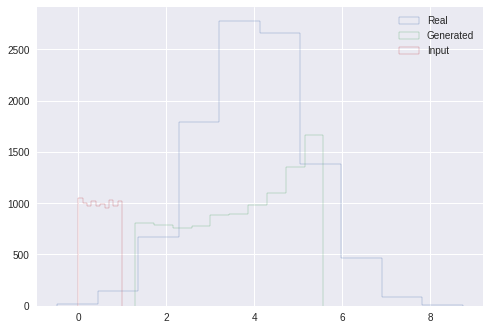

epoch: 1439 // mu and std of Real: (3.999536982612353, 1.2341748238800407)
mu and std of Gen: (3.7373948, 1.2746438)


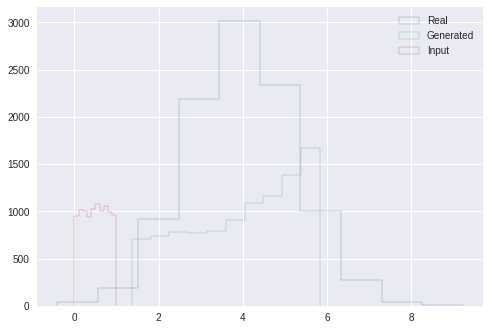

epoch: 1449 // mu and std of Real: (3.9830719349365027, 1.248324336377227)
mu and std of Gen: (3.9610336, 1.3072329)


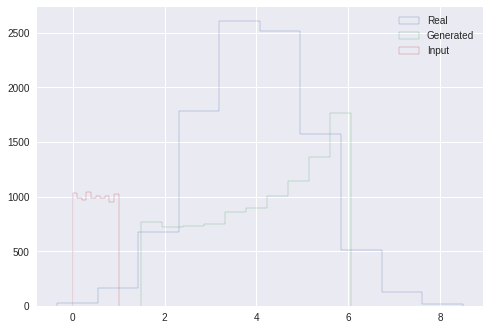

epoch: 1459 // mu and std of Real: (3.991313332402354, 1.243762932143058)
mu and std of Gen: (4.159212, 1.35205)


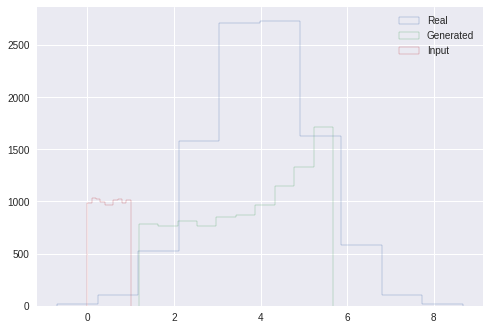

epoch: 1469 // mu and std of Real: (4.008466175199404, 1.2474461292419632)
mu and std of Gen: (3.7635384, 1.3402922)


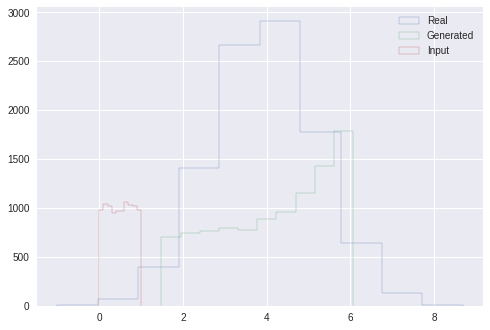

epoch: 1479 // mu and std of Real: (3.987615621040556, 1.2526308816325569)
mu and std of Gen: (4.176845, 1.3539252)


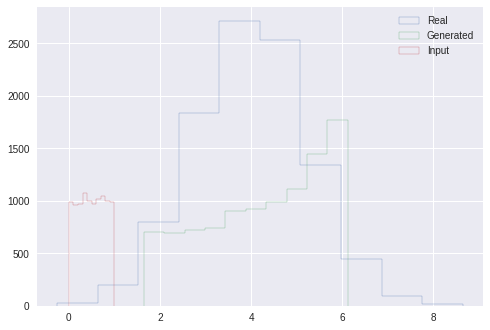

epoch: 1489 // mu and std of Real: (4.004701321218054, 1.2448432312406021)
mu and std of Gen: (4.2823424, 1.3115529)


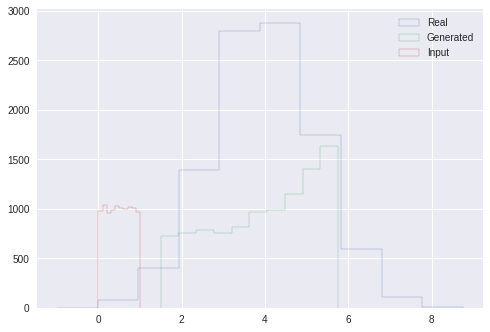

epoch: 1499 // mu and std of Real: (3.9904130163556752, 1.2437489016017103)
mu and std of Gen: (3.9572792, 1.249264)


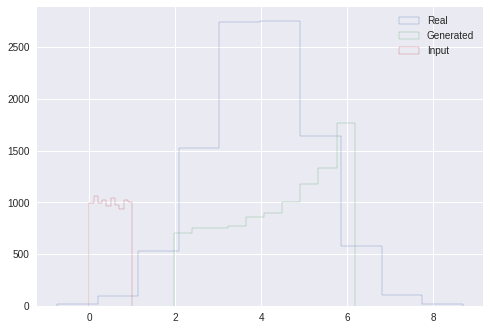

epoch: 1509 // mu and std of Real: (4.00301325228787, 1.2595056074811382)
mu and std of Gen: (4.4227057, 1.2337179)


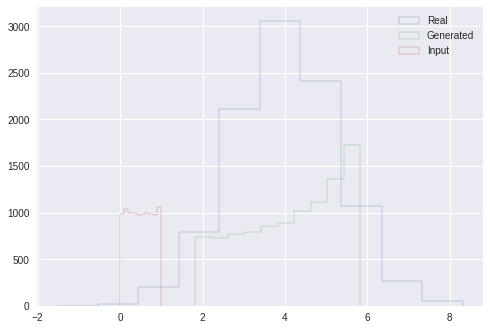

epoch: 1519 // mu and std of Real: (3.998989777036485, 1.2649264998746823)
mu and std of Gen: (4.1437306, 1.1830682)


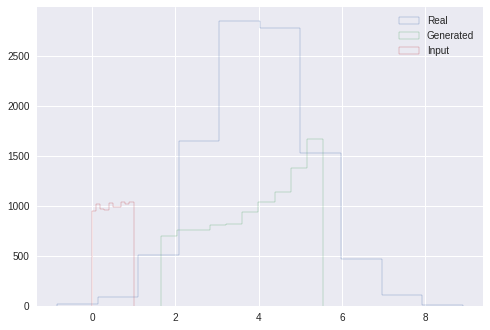

epoch: 1529 // mu and std of Real: (4.006016504958396, 1.2615999077241147)
mu and std of Gen: (3.9172914, 1.1437577)


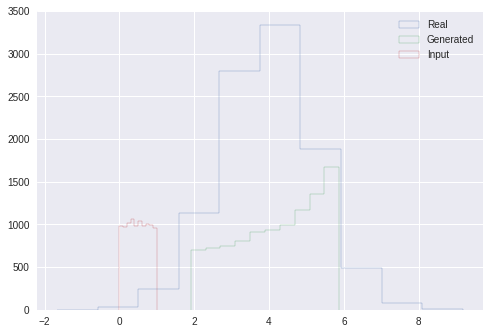

epoch: 1539 // mu and std of Real: (3.9963477289142624, 1.2417915292273431)
mu and std of Gen: (4.2099304, 1.1549425)


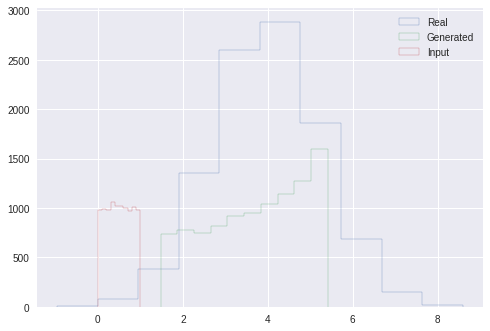

epoch: 1549 // mu and std of Real: (3.999520948417517, 1.251922786052475)
mu and std of Gen: (3.7234566, 1.1497684)


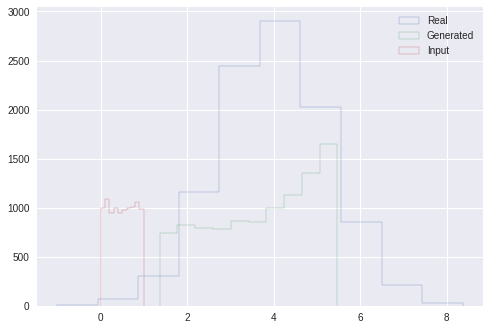

epoch: 1559 // mu and std of Real: (4.010324399527434, 1.2528631605590768)
mu and std of Gen: (3.712548, 1.2172022)


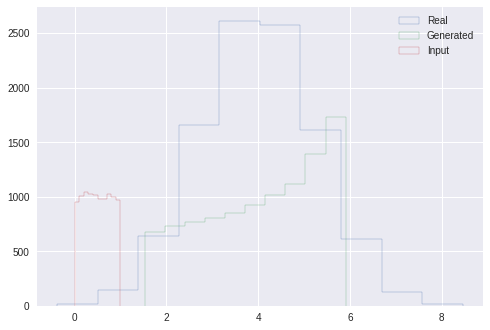

epoch: 1569 // mu and std of Real: (4.016395848910584, 1.2398041758919522)
mu and std of Gen: (4.0829177, 1.2753367)


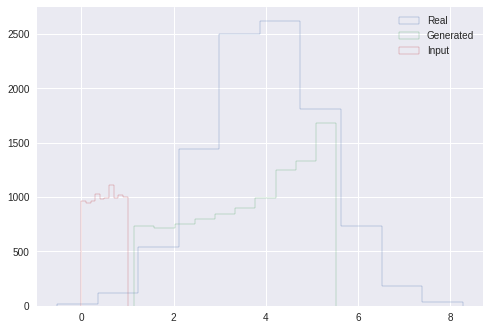

epoch: 1579 // mu and std of Real: (3.9955447462101845, 1.2529671103304394)
mu and std of Gen: (3.6916804, 1.2861732)


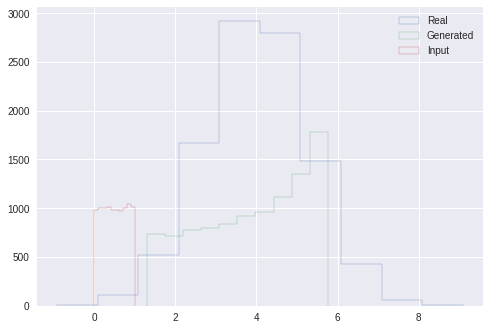

epoch: 1589 // mu and std of Real: (4.011473834552635, 1.2587868833224978)
mu and std of Gen: (3.8914332, 1.3213019)


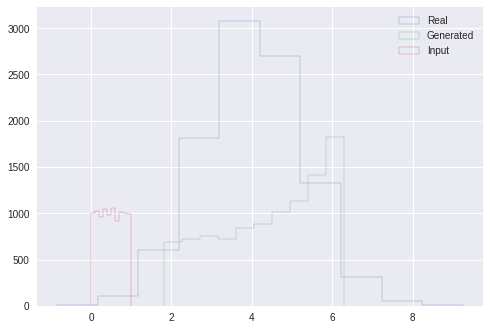

epoch: 1599 // mu and std of Real: (4.010206989606121, 1.246458126203367)
mu and std of Gen: (4.4637165, 1.3111285)


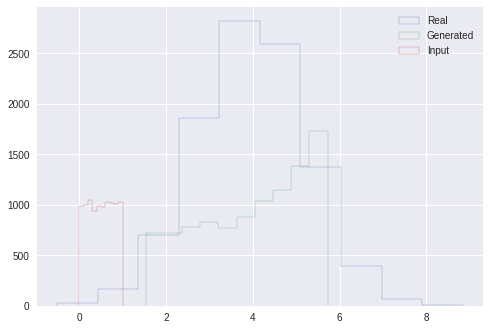

epoch: 1609 // mu and std of Real: (3.976031666018009, 1.2459942532472204)
mu and std of Gen: (3.974275, 1.234945)


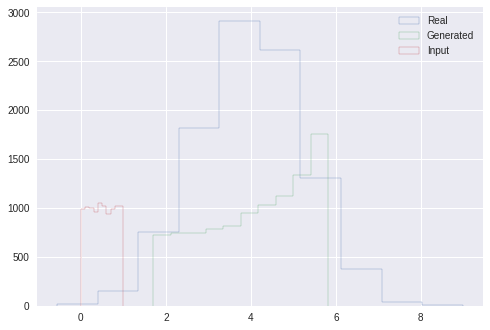

epoch: 1619 // mu and std of Real: (3.9993918773909303, 1.2451087785120896)
mu and std of Gen: (4.0974984, 1.2110943)


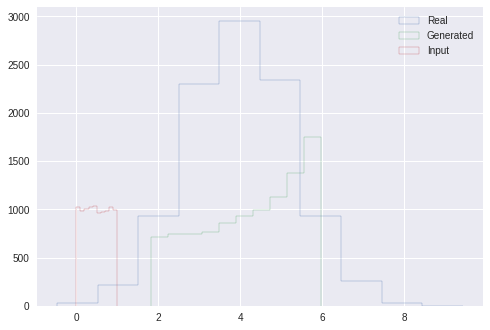

epoch: 1629 // mu and std of Real: (4.006260748019431, 1.2729311067005016)
mu and std of Gen: (4.2391405, 1.2188348)


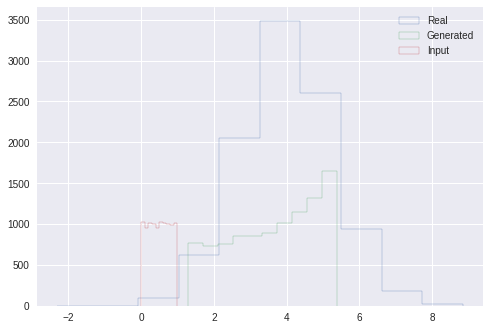

epoch: 1639 // mu and std of Real: (3.994376557921723, 1.251473791034392)
mu and std of Gen: (3.6377554, 1.2062322)


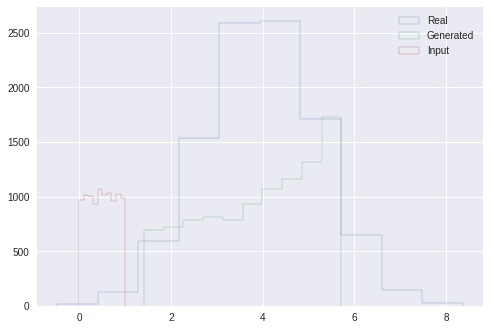

epoch: 1649 // mu and std of Real: (3.989603028924369, 1.2429550684202286)
mu and std of Gen: (3.9220047, 1.2611762)


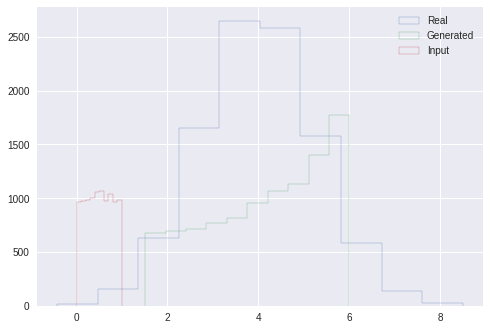

epoch: 1659 // mu and std of Real: (4.009998603823019, 1.2518871564385858)
mu and std of Gen: (4.162078, 1.3059571)


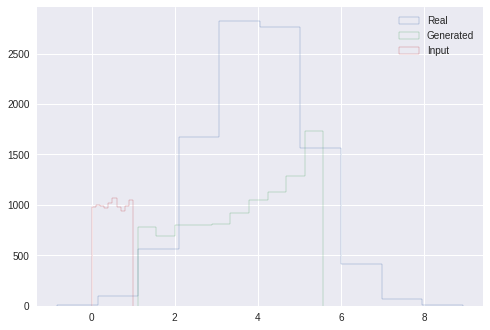

epoch: 1669 // mu and std of Real: (3.9866645241398, 1.2559699511899558)
mu and std of Gen: (3.6871874, 1.3207942)


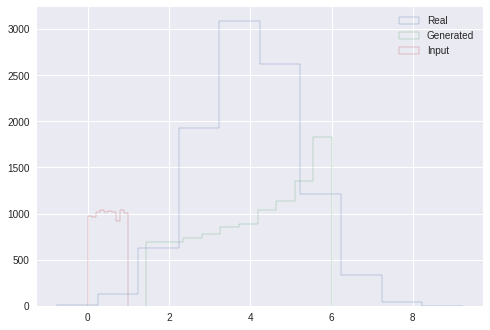

epoch: 1679 // mu and std of Real: (4.002961140311644, 1.2472988103112395)
mu and std of Gen: (4.130016, 1.3403107)


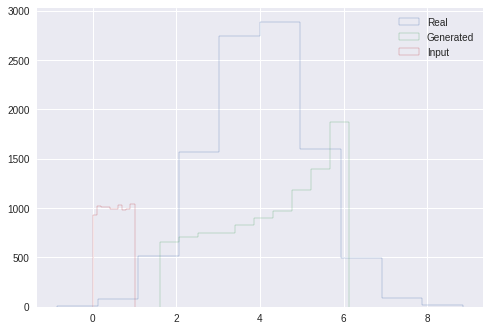

epoch: 1689 // mu and std of Real: (4.00651610952797, 1.2546082902429205)
mu and std of Gen: (4.2955756, 1.3285136)


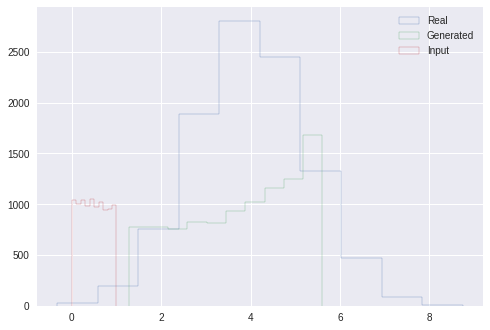

epoch: 1699 // mu and std of Real: (4.007409918403843, 1.2474689497292293)
mu and std of Gen: (3.7594657, 1.2766944)


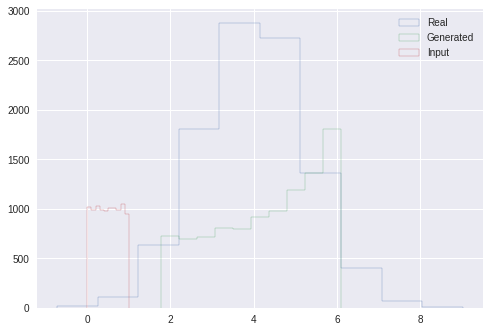

epoch: 1709 // mu and std of Real: (4.008084654457301, 1.2532831347917517)
mu and std of Gen: (4.3174515, 1.2719772)


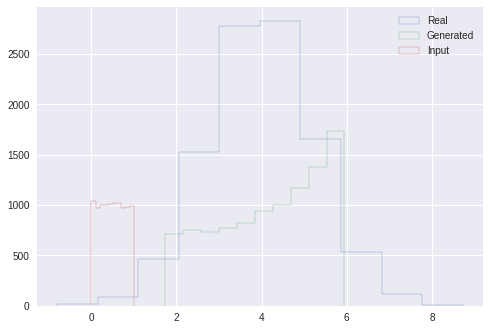

epoch: 1719 // mu and std of Real: (4.004179134113365, 1.238270377523174)
mu and std of Gen: (4.1946807, 1.233701)


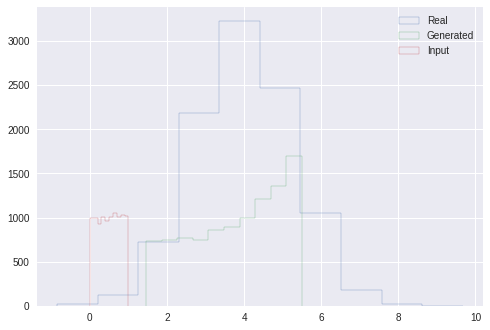

epoch: 1729 // mu and std of Real: (4.0072584101681405, 1.2521077805757024)
mu and std of Gen: (3.8081207, 1.1881853)


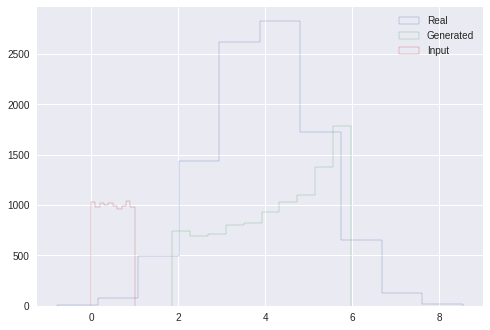

epoch: 1739 // mu and std of Real: (3.9829413173303605, 1.244102061158195)
mu and std of Gen: (4.2717757, 1.2098213)


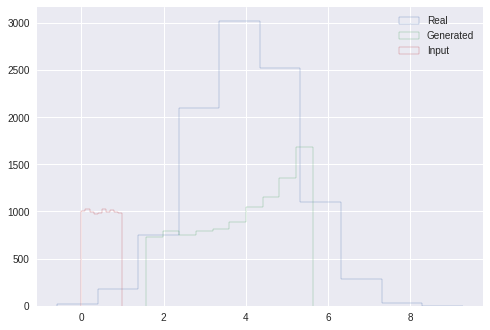

epoch: 1749 // mu and std of Real: (4.002077872773586, 1.252238885224165)
mu and std of Gen: (3.9180067, 1.19368)


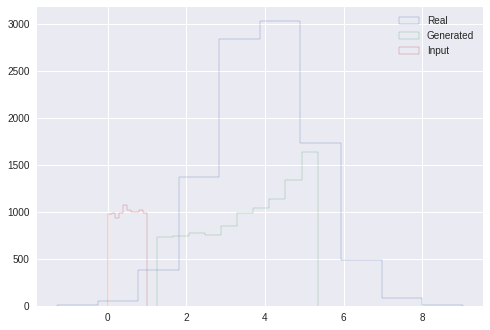

epoch: 1759 // mu and std of Real: (3.978128944458419, 1.2619333842267122)
mu and std of Gen: (3.6055355, 1.1955447)


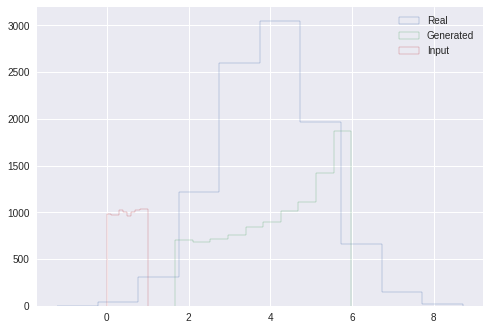

epoch: 1769 // mu and std of Real: (4.009048129496403, 1.2462457041764363)
mu and std of Gen: (4.2304373, 1.2656984)


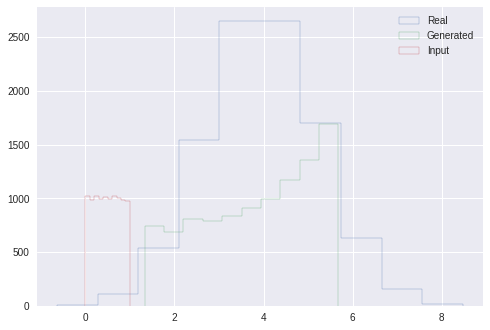

epoch: 1779 // mu and std of Real: (3.9829220080200045, 1.2490874512173862)
mu and std of Gen: (3.8519008, 1.2779953)


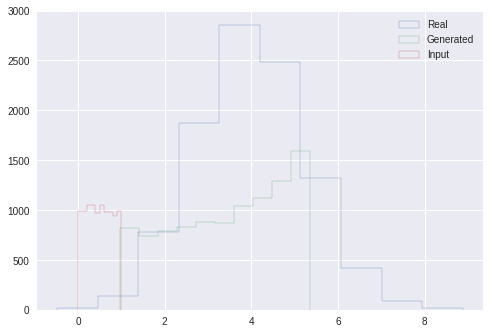

epoch: 1789 // mu and std of Real: (4.0011112350237426, 1.2634674606660585)
mu and std of Gen: (3.4445906, 1.2985978)


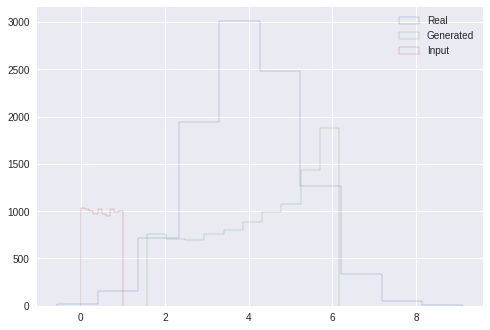

epoch: 1799 // mu and std of Real: (4.012572561708186, 1.2548350123097853)
mu and std of Gen: (4.2753615, 1.3628179)


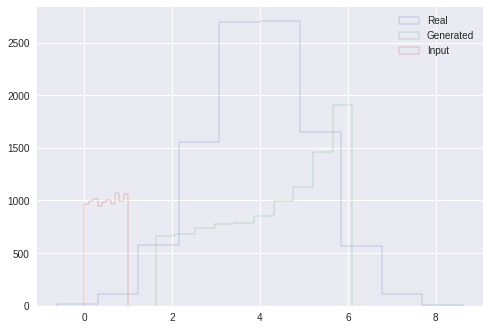

epoch: 1809 // mu and std of Real: (4.0065655276959635, 1.2486432747472407)
mu and std of Gen: (4.300512, 1.3175601)


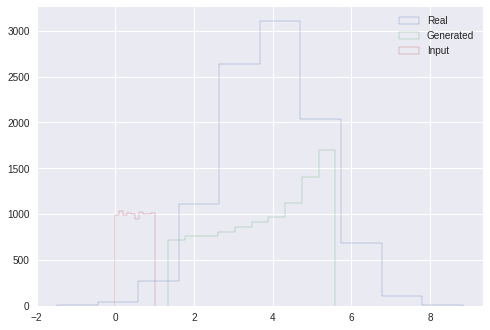

epoch: 1819 // mu and std of Real: (3.9827900773958165, 1.25786003176067)
mu and std of Gen: (3.8007984, 1.2542608)


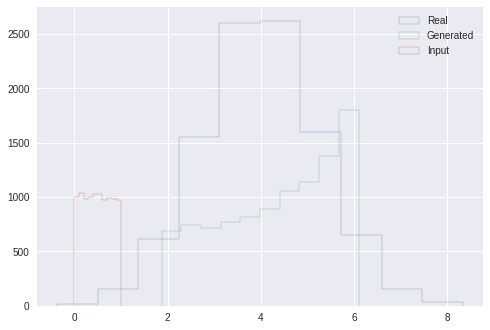

epoch: 1829 // mu and std of Real: (4.005655267293702, 1.2363400806041365)
mu and std of Gen: (4.356869, 1.2405406)


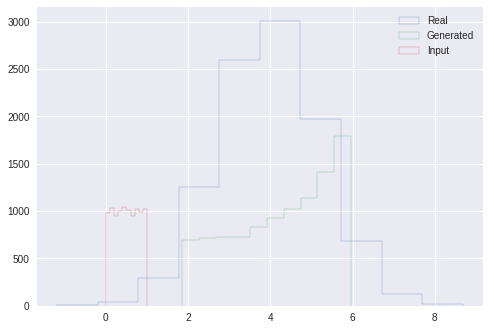

epoch: 1839 // mu and std of Real: (4.002376334658274, 1.2451182533214256)
mu and std of Gen: (4.2839384, 1.2060174)


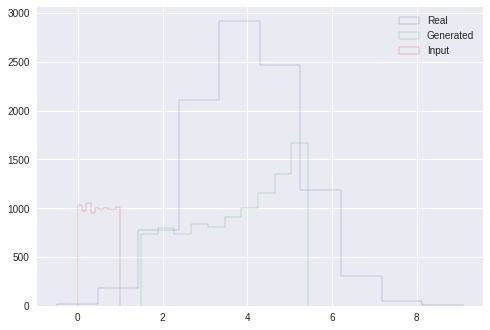

epoch: 1849 // mu and std of Real: (3.984632142595559, 1.237769230202097)
mu and std of Gen: (3.7639375, 1.1635917)


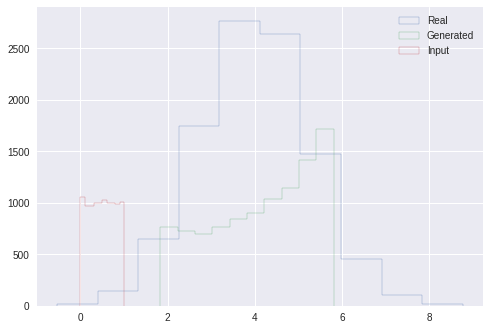

epoch: 1859 // mu and std of Real: (4.013332446104142, 1.2541015799971142)
mu and std of Gen: (4.152485, 1.1750644)


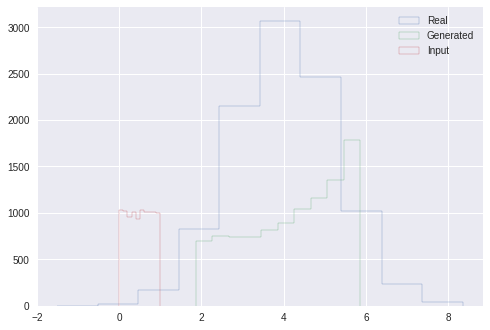

epoch: 1869 // mu and std of Real: (4.015095171775063, 1.2412605247754032)
mu and std of Gen: (4.2011924, 1.175734)


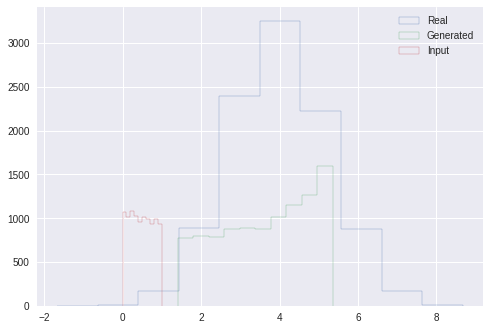

epoch: 1879 // mu and std of Real: (3.990512156230339, 1.238821659107887)
mu and std of Gen: (3.6354792, 1.1645095)


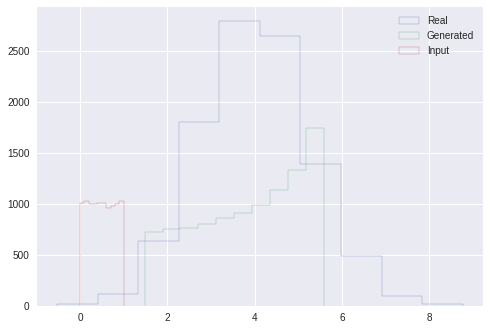

epoch: 1889 // mu and std of Real: (4.014861241450673, 1.2448723964662907)
mu and std of Gen: (3.8563964, 1.2091006)


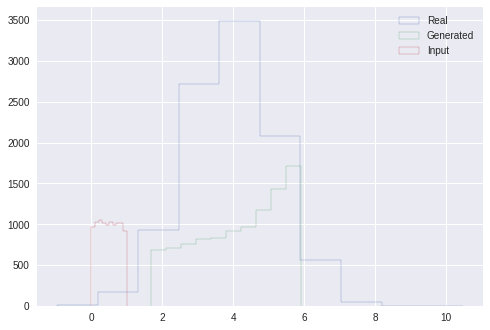

epoch: 1899 // mu and std of Real: (3.983288322998761, 1.2464583454897866)
mu and std of Gen: (4.164811, 1.2374448)


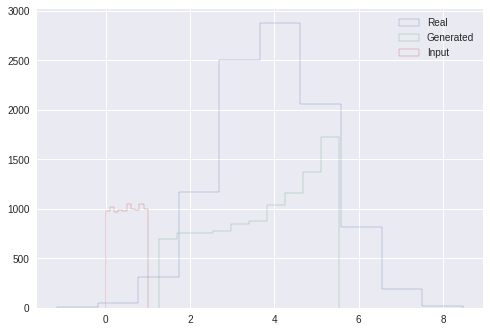

epoch: 1909 // mu and std of Real: (3.9809114878219014, 1.2582606137619723)
mu and std of Gen: (3.7526138, 1.2532744)


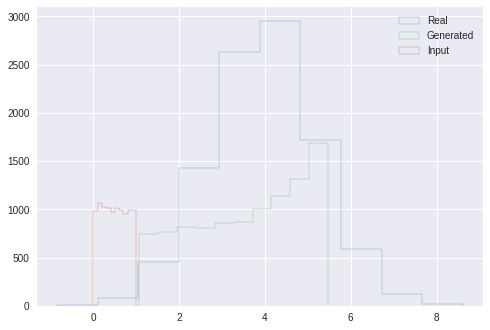

epoch: 1919 // mu and std of Real: (3.988844784385672, 1.2339618500640457)
mu and std of Gen: (3.5916636, 1.3026044)


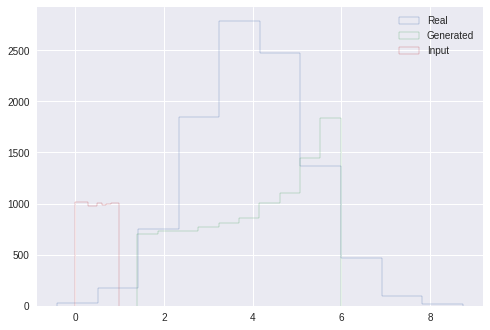

epoch: 1929 // mu and std of Real: (3.9911031082024953, 1.2613821538021635)
mu and std of Gen: (4.11091, 1.357836)


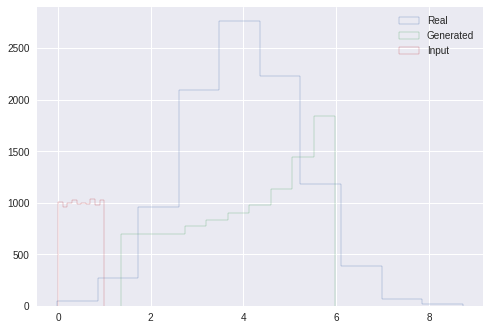

epoch: 1939 // mu and std of Real: (4.010597711179427, 1.2344744174999107)
mu and std of Gen: (4.095306, 1.3613225)


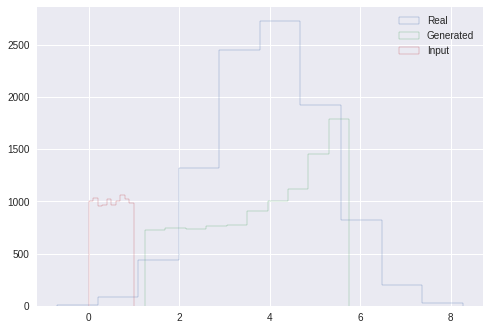

epoch: 1949 // mu and std of Real: (4.006487274105995, 1.2472970568604795)
mu and std of Gen: (3.896541, 1.3354144)


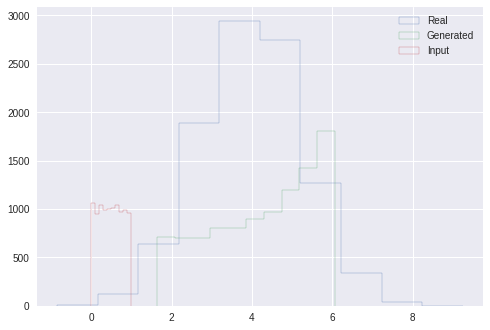

epoch: 1959 // mu and std of Real: (3.9868321761836114, 1.266074577231287)
mu and std of Gen: (4.2492986, 1.3012017)


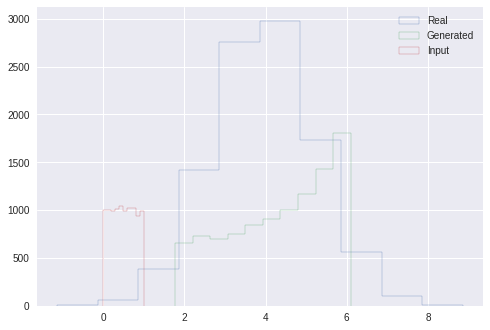

epoch: 1969 // mu and std of Real: (3.979546663400194, 1.2515952771943977)
mu and std of Gen: (4.3375697, 1.2615818)


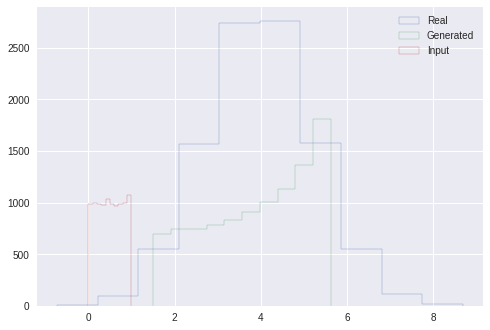

epoch: 1979 // mu and std of Real: (3.9934688032932057, 1.251782398179998)
mu and std of Gen: (3.9219642, 1.2109956)


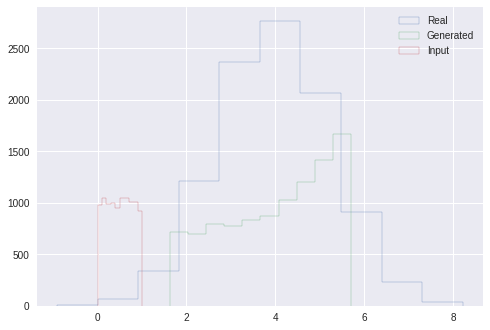

epoch: 1989 // mu and std of Real: (3.989856211149828, 1.2596328606759584)
mu and std of Gen: (4.007201, 1.195835)


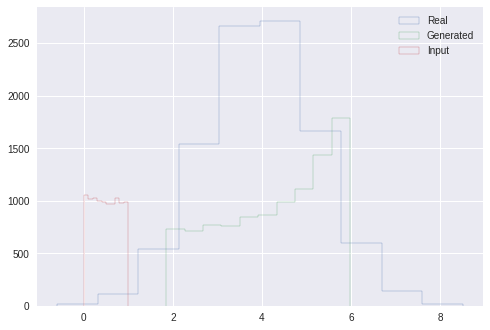

epoch: 1999 // mu and std of Real: (3.9972561125550623, 1.2454124091476129)
mu and std of Gen: (4.269235, 1.2208607)


In [14]:
main()